In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from tqdm.notebook import tqdm
import torch.nn.functional as F

from utils.dataset_utils import ChemistryData, transform_data, log_normalize_data, inverse_log_normalize_data, inverse_transform_data

from utils.net_utils import UNet

from utils.learning_utils import compute_weighted_loss_on_several_predictions, process_one_epoch, LO, LH, MSE

from utils.plot_utils import plot_losses, predict_on_many_steps, predict_on_one_step, \
                       one_step_approximation_errors, print_errors, plot_errors, validate_prediction

In [2]:
# Параметры
BATCH_SIZE = 512 #args.batch_size
LATENT_DIM = 100 #args.latent_dim
LEVEL_NUM = 1 #args.level_number
STEPS_PREV = 1 # количество шагов, по которым будем предсказывать
STEPS_NEXT = 30 # количество шагов, на которое будем предсказывать
NETWORK_NAME = f'UNET_one_pressure_Levels{LEVEL_NUM}_LatentDim{LATENT_DIM}_STEPS_NEXT{STEPS_NEXT}'
EPOCHS_NUM = 100 #args.epochs
validation_experiment = 4 #args.validation_experiment

device = torch.device("cuda:0" if torch.cuda.is_available () else "cpu")
print(device, torch.cuda.is_available())

cuda:0 True


## Обучение модели

In [4]:
# считывание данных
train_set = ChemistryData(filename='data/train_set.npy', t_prev=STEPS_PREV, t_next=STEPS_NEXT, transforms=transform_data, coeffs=None)
test_set = ChemistryData(filename='data/test_set.npy', t_prev=STEPS_PREV, t_next=STEPS_NEXT, transforms=transform_data, coeffs=train_set.coeffs)
valid_set = ChemistryData(filename='data/valid_set.npy', t_prev=STEPS_PREV, t_next=STEPS_NEXT, transforms=transform_data, coeffs=train_set.coeffs)

# создание загрузчиков данных для удобства обучения
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_set), len(test_set), len(valid_set))
print(len(train_loader), len(test_loader), len(valid_loader))

# создание модели нейронной сети
input_dim = 11
output_dim = 9 #последние два копируются из входа
latent_dim = LATENT_DIM
model = UNet(t_prev=STEPS_PREV, t_next=STEPS_NEXT,
             #input_embedding = nn.Sequential(nn.Linear(input_dim, LATENT_DIM), nn.InstanceNorm1d(LATENT_DIM)),
             #input_embedding = nn.Sequential(nn.Linear(input_dim, LATENT_DIM), Flatten_and_Batchnorm(LATENT_DIM)),
             input_embedding = nn.Sequential(nn.Linear(input_dim, LATENT_DIM)), #nn.LeakyReLU(0.15)),
             output_embedding = nn.Sequential(nn.Linear(LATENT_DIM, output_dim)),
             latent_dim=LATENT_DIM,
             slope=0.15,
             level_number=LEVEL_NUM
        ).to(device)
#MSE = nn.MSELoss(reduction='mean')

3760000 752000 188000
7344 1469 368


## Загрузка обученной модели

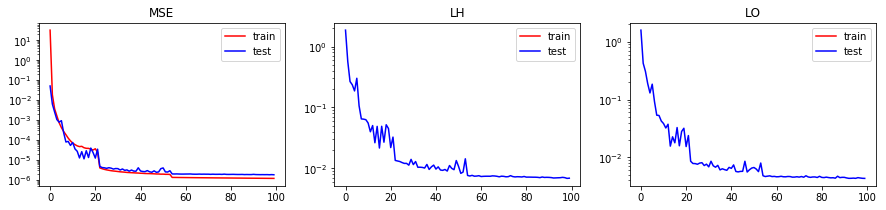

In [7]:
epoch = 99
A = torch.load('./checkpoints/{}/{}_epoch_{}_LH_LO.pth'.format(NETWORK_NAME, NETWORK_NAME, epoch))
model.load_state_dict(A['model_state_dict'])
model.eval()
train_loss_history = A['train_loss']
test_loss_history = A['test_loss']
plot_losses(train_loss_history, test_loss_history, NETWORK_NAME)

constant_approximation MSE:	 0.0018508561
constant_approximation MAE:	 0.0053882985
предсказание нейронной сети на один шаг вперёд:
MSE:	 5.055193e-07
MAE:	 0.00019680115
предсказание нейронной сети на много шагов вперёд:
MSE:	 3.4684763e-06
MAE:	 0.0011851303


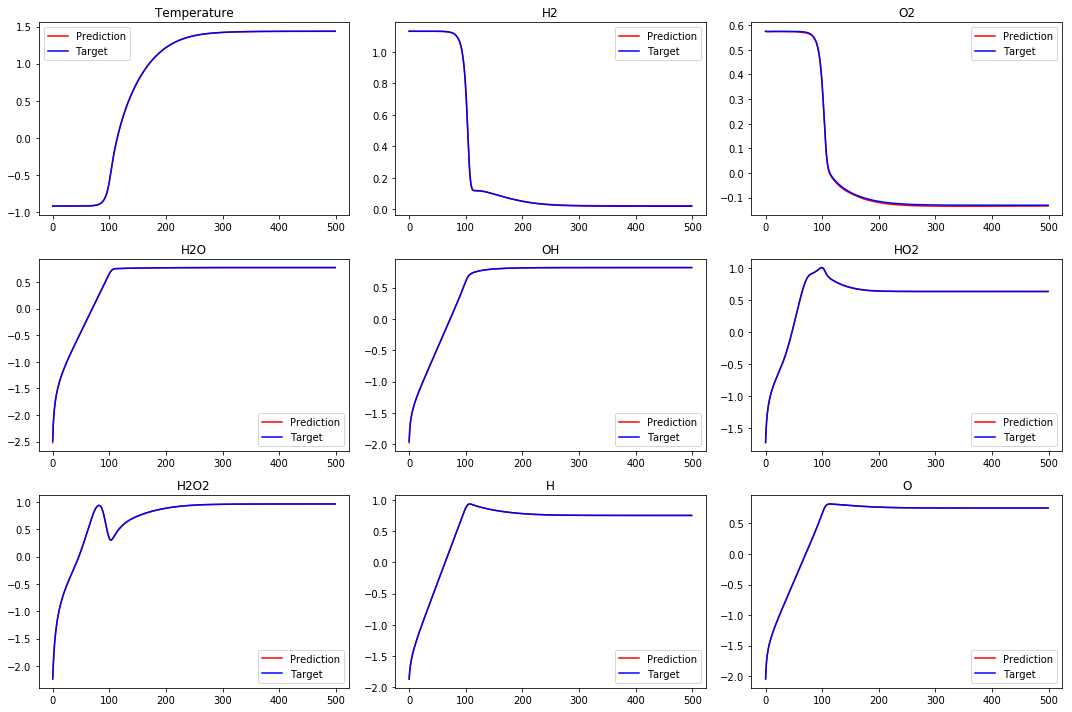

In [10]:
prediction, validation = validate_prediction(model, STEPS_PREV, valid_set, 1, device, NETWORK_NAME, nsteps=500, show=True)

In [46]:
def plot_errors(Prediction, Validation, nsteps, NETWORK_NAME, show=True):

    # Построим графики для сравнения
    fig, axs = plt.subplots(3, 3, figsize=(15,10))
    axs[0,0].plot(Prediction[:nsteps, 0], color='b', marker='o', linestyle='None',
                                          markeredgecolor='b', markerfacecolor='w', markersize=5, 
                  label = 'Prediction')
    axs[0,0].plot(Validation[:nsteps, 0], color='r', label = 'Target')
    axs[0,0].set_title('Temperature')
    axs[0,0].legend()
    
    titles = ['T', 'H2', 'O2', 'H2O', 'OH', 'HO2', 'H2O2', 'H', 'O']
    
    for k in range(1, 9):
        i = k // 3
        j = k % 3
        axs[i, j].plot(Prediction[:nsteps, k], color='b', marker='o', linestyle='None',
                                               markeredgecolor='b', markerfacecolor='w', markersize=5,  
                       label = 'Prediction')
        axs[i, j].plot(Validation[:nsteps, k], color='r', label = 'Target')
        axs[i, j].set_title(titles[k])
        axs[i, j].legend()
    plt.tight_layout()
    if show:
        plt.show()
    else:
        fig.savefig(NETWORK_NAME + '_Prediction_future_components.png', dpi=600)
        
def validate_prediction(model, STEPS_PREV, valid_set, validation_experiment, device, NETWORK_NAME, nsteps, show=True):    
    # Берём один эксперимент из данных из валидационной выборки  
    Validation = torch.FloatTensor(valid_set.data[validation_experiment]).to(device).unsqueeze(1)
    
    # Стартовое состояние X0
    X0 = Validation[:STEPS_PREV, :, :]
    N_steps = len(Validation) - 1
    Prediction_future = predict_on_many_steps(model=model, X0=X0, N_steps=nsteps)
    Prediction_one_step = predict_on_one_step(model=model, Validation=Validation, device=device, t_prev=1)
    Validation = Validation.squeeze().cpu().detach().numpy()

#     one_step_approximation_errors(Validation)
#     print('предсказание нейронной сети на один шаг вперёд:')
#     print_errors(Prediction_one_step, Validation)
#     print('предсказание нейронной сети на много шагов вперёд:')
#     print_errors(Prediction_future[:N_steps], Validation[1:])

    plot_errors(Prediction_future, Validation[1:], nsteps=nsteps, NETWORK_NAME=NETWORK_NAME, show=show)
    return Prediction_future, Validation

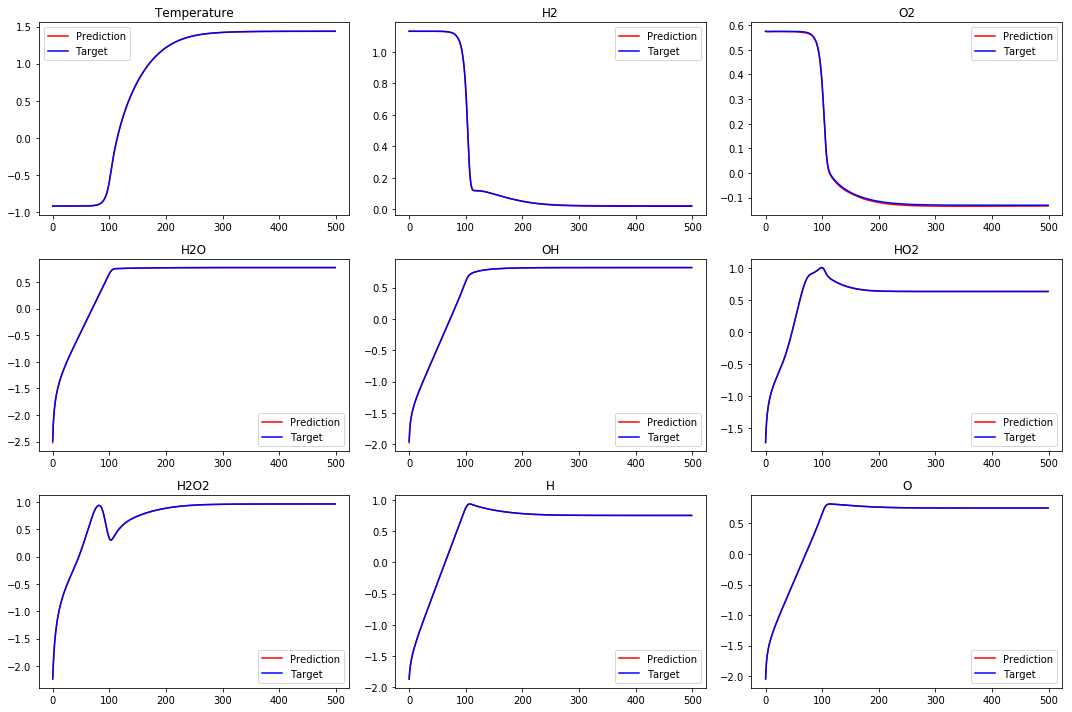

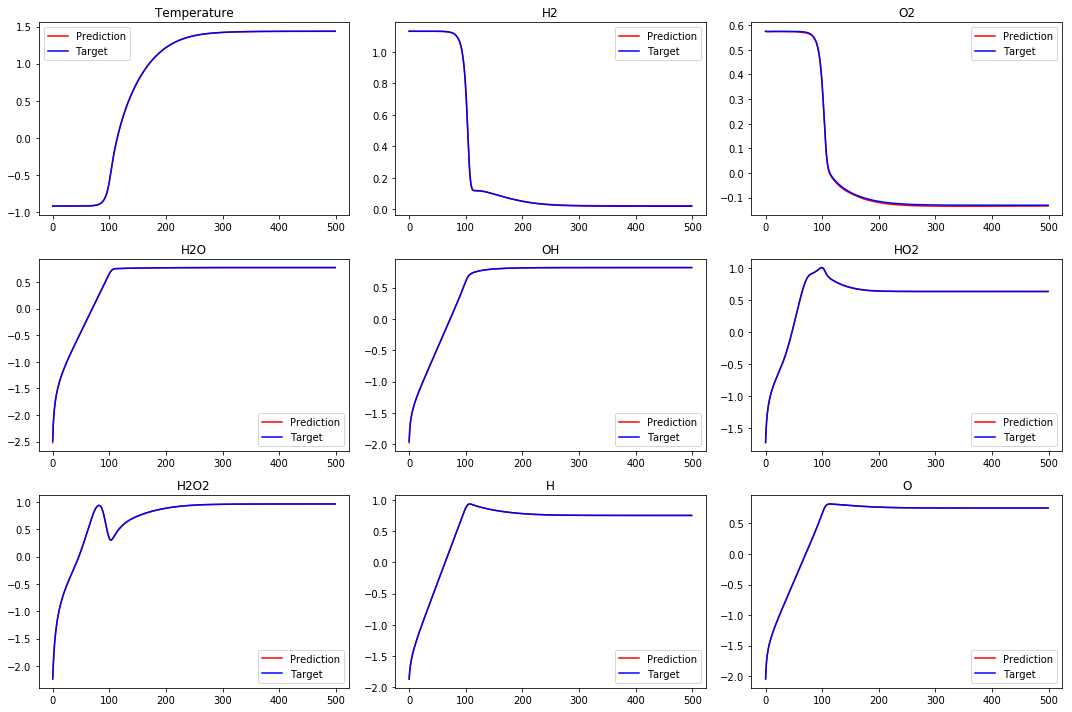

In [39]:
prediction, validation = validate_prediction(model, STEPS_PREV, valid_set, 1, device, NETWORK_NAME, nsteps=500, show=True)
prediction, validation = validate_prediction(model, STEPS_PREV, valid_set, 1, device, NETWORK_NAME, nsteps=500, show=False)

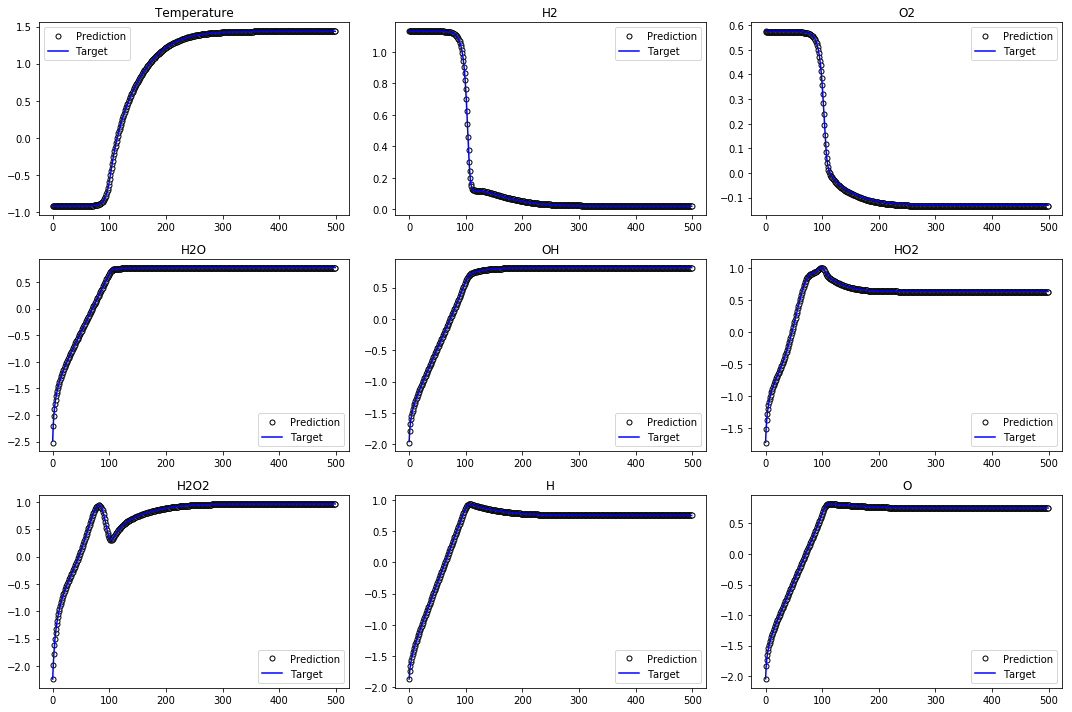

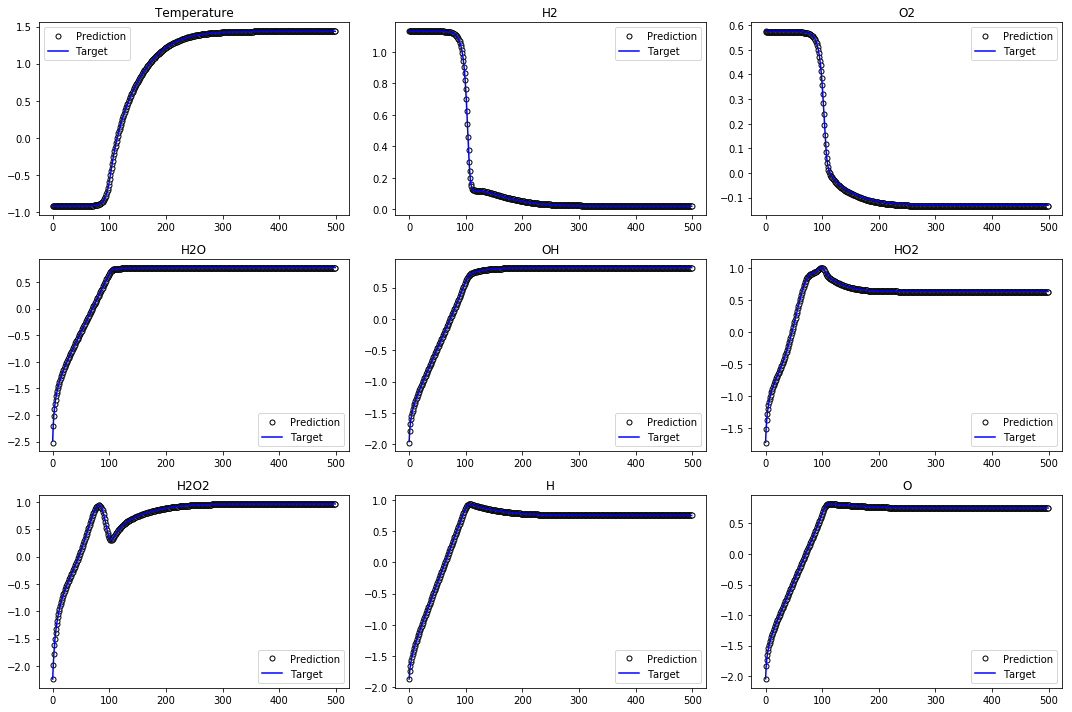

In [36]:
prediction, validation = validate_prediction(model, STEPS_PREV, valid_set, 1, device, NETWORK_NAME, nsteps=500, show=True)
prediction, validation = validate_prediction(model, STEPS_PREV, valid_set, 1, device, NETWORK_NAME, nsteps=500, show=False)

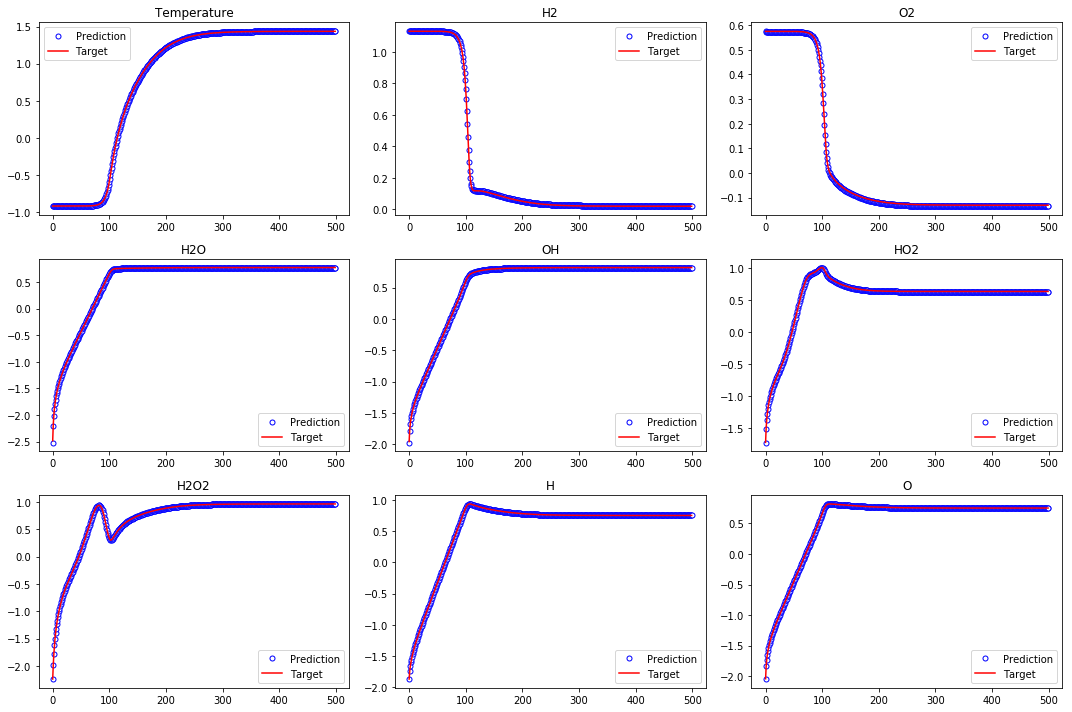

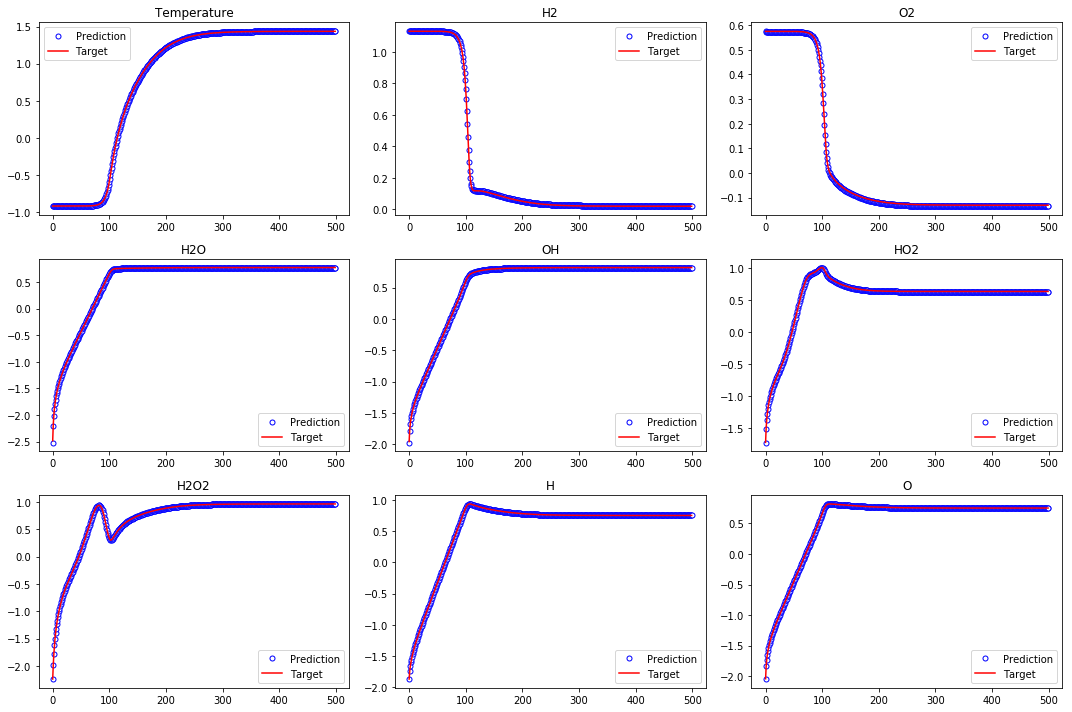

In [47]:
prediction, validation = validate_prediction(model, STEPS_PREV, valid_set, 1, device, NETWORK_NAME, nsteps=500, show=True)
prediction, validation = validate_prediction(model, STEPS_PREV, valid_set, 1, device, NETWORK_NAME, nsteps=500, show=False)

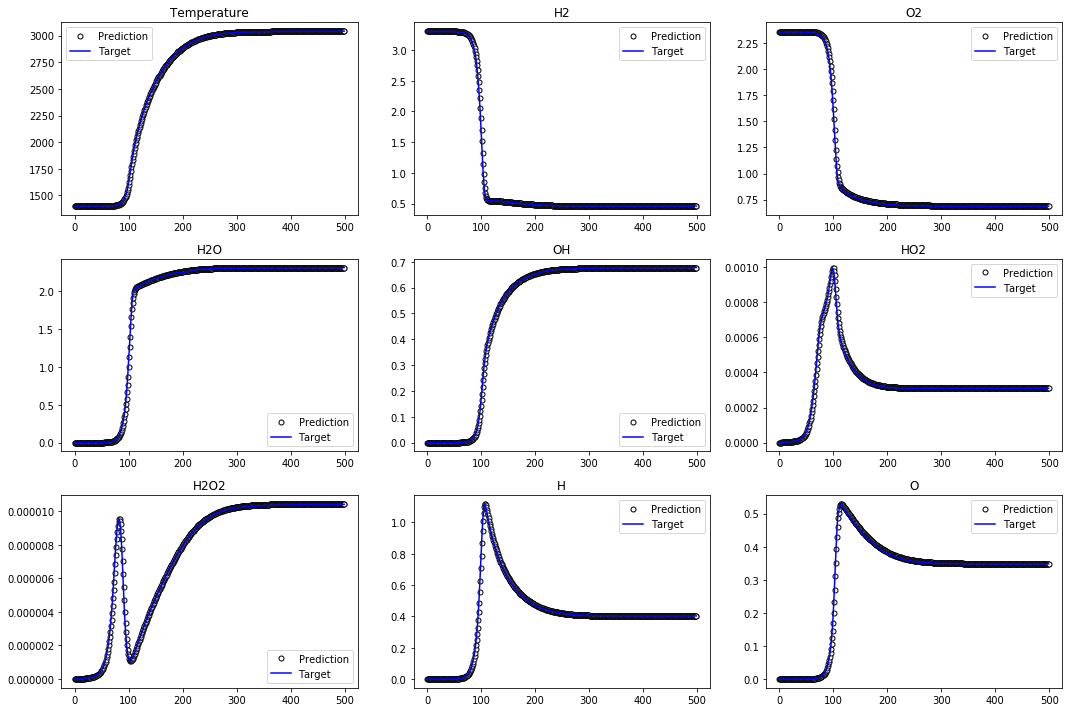

tensor([1.1298e+00, 8.0842e-06, 3.1457e-05, 3.1161e-05, 1.4884e-06, 7.4674e-12,
        1.9786e-15, 4.1511e-06, 4.2035e-06, 0.0000e+00, 0.0000e+00]) tensor([9.0002e-01, 2.2514e-03, 5.3759e-03, 3.8674e-03, 7.7657e-04, 2.1352e-06,
        3.7836e-08, 1.5527e-03, 1.3963e-03, 0.0000e+00, 0.0000e+00])


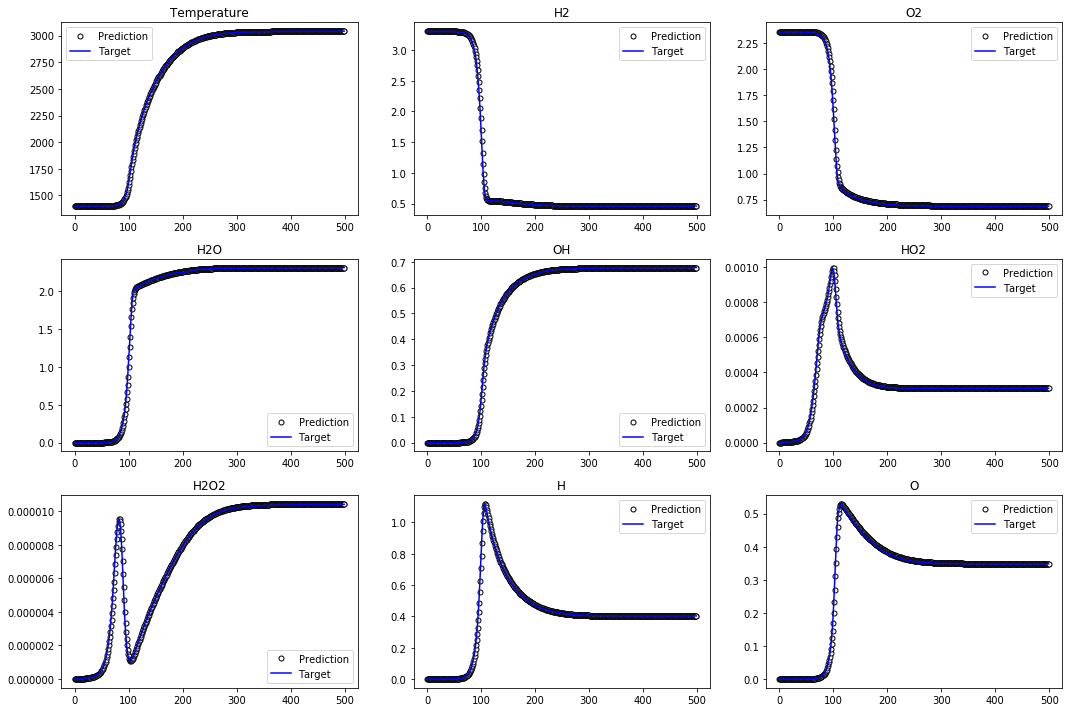

In [43]:
inv_validation = inverse_transform_data(torch.tensor(validation[:, :]), train_set.coeffs)
inv_prediction = inverse_transform_data(prediction[:, :], train_set.coeffs)
plot_errors(inv_validation, inv_prediction, nsteps=500, NETWORK_NAME=NETWORK_NAME, show=True)
print(((inv_validation[1:] - inv_prediction)**2).mean(axis=0), np.abs(inv_validation[1:] - inv_prediction).mean(axis=0))
plot_errors(inv_validation, inv_prediction, nsteps=500, NETWORK_NAME=NETWORK_NAME, show=False)

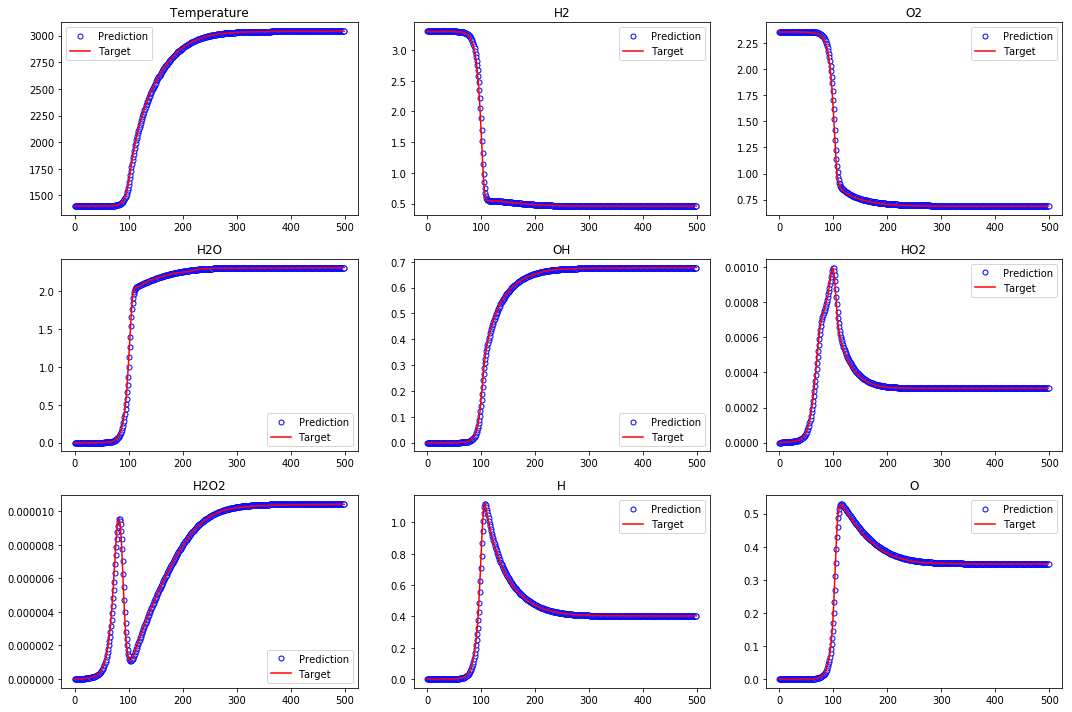

tensor([1.1298e+00, 8.0842e-06, 3.1457e-05, 3.1161e-05, 1.4884e-06, 7.4674e-12,
        1.9786e-15, 4.1511e-06, 4.2035e-06, 0.0000e+00, 0.0000e+00]) tensor([9.0002e-01, 2.2514e-03, 5.3759e-03, 3.8674e-03, 7.7657e-04, 2.1352e-06,
        3.7836e-08, 1.5527e-03, 1.3963e-03, 0.0000e+00, 0.0000e+00])


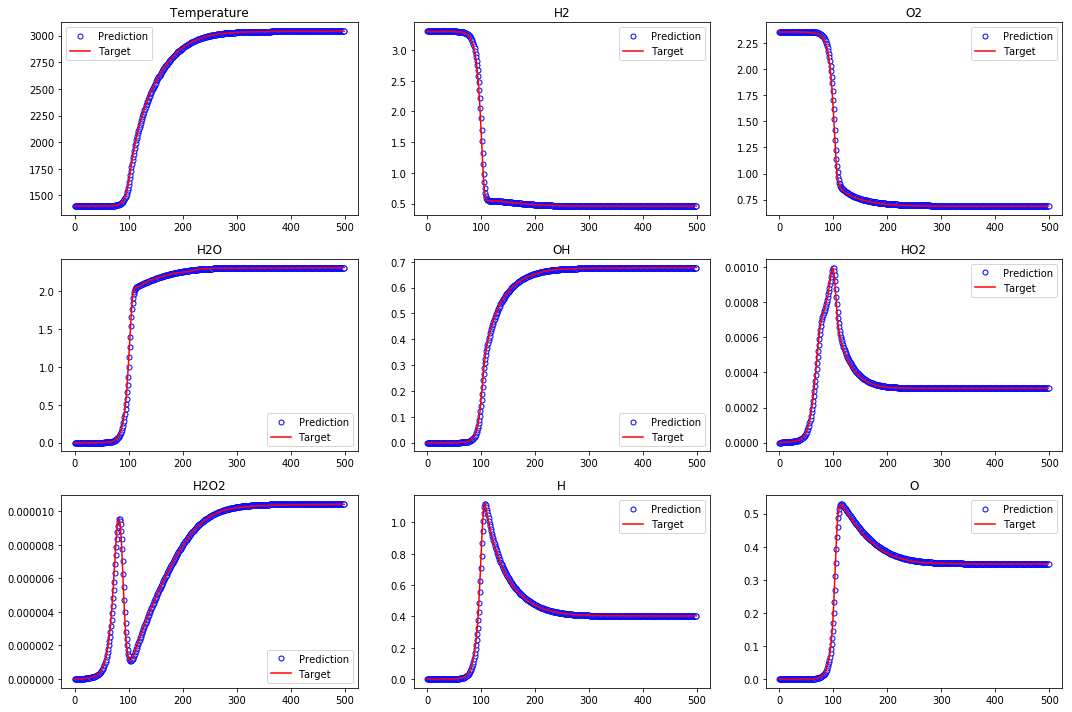

In [48]:
inv_validation = inverse_transform_data(torch.tensor(validation[:, :]), train_set.coeffs)
inv_prediction = inverse_transform_data(prediction[:, :], train_set.coeffs)
plot_errors(inv_validation, inv_prediction, nsteps=500, NETWORK_NAME=NETWORK_NAME, show=True)
print(((inv_validation[1:] - inv_prediction)**2).mean(axis=0), np.abs(inv_validation[1:] - inv_prediction).mean(axis=0))
plot_errors(inv_validation, inv_prediction, nsteps=500, NETWORK_NAME=NETWORK_NAME, show=False)

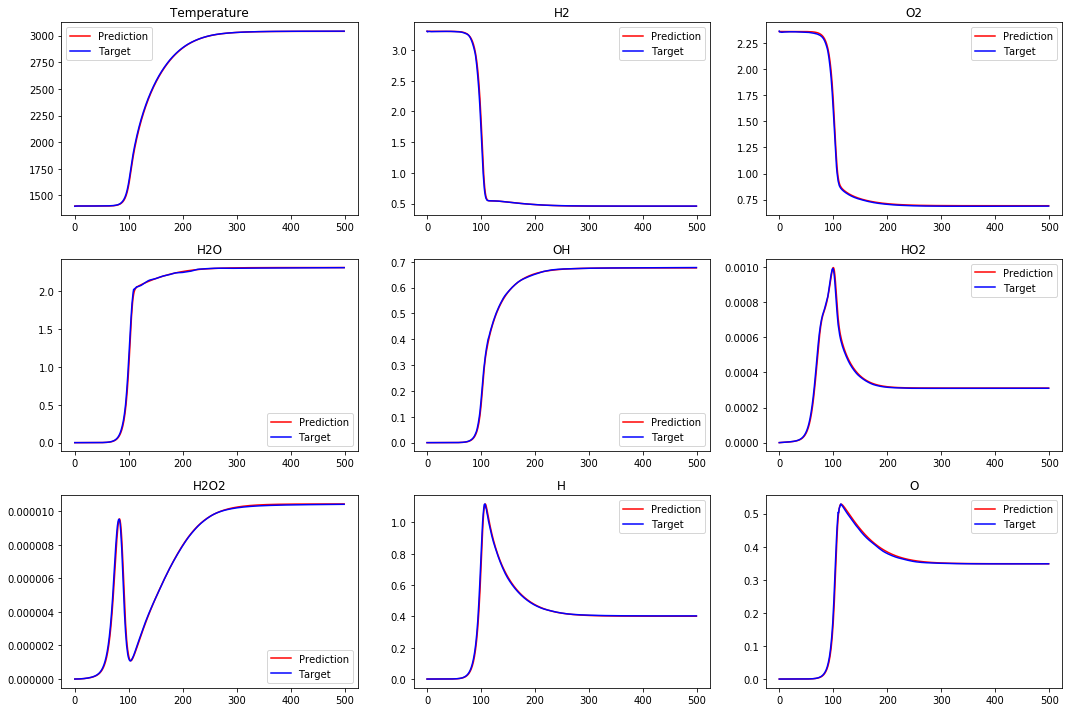

tensor([1.1298e+00, 8.0842e-06, 3.1457e-05, 3.1161e-05, 1.4884e-06, 7.4674e-12,
        1.9786e-15, 4.1511e-06, 4.2035e-06, 0.0000e+00, 0.0000e+00]) tensor([9.0002e-01, 2.2514e-03, 5.3759e-03, 3.8674e-03, 7.7657e-04, 2.1352e-06,
        3.7836e-08, 1.5527e-03, 1.3963e-03, 0.0000e+00, 0.0000e+00])


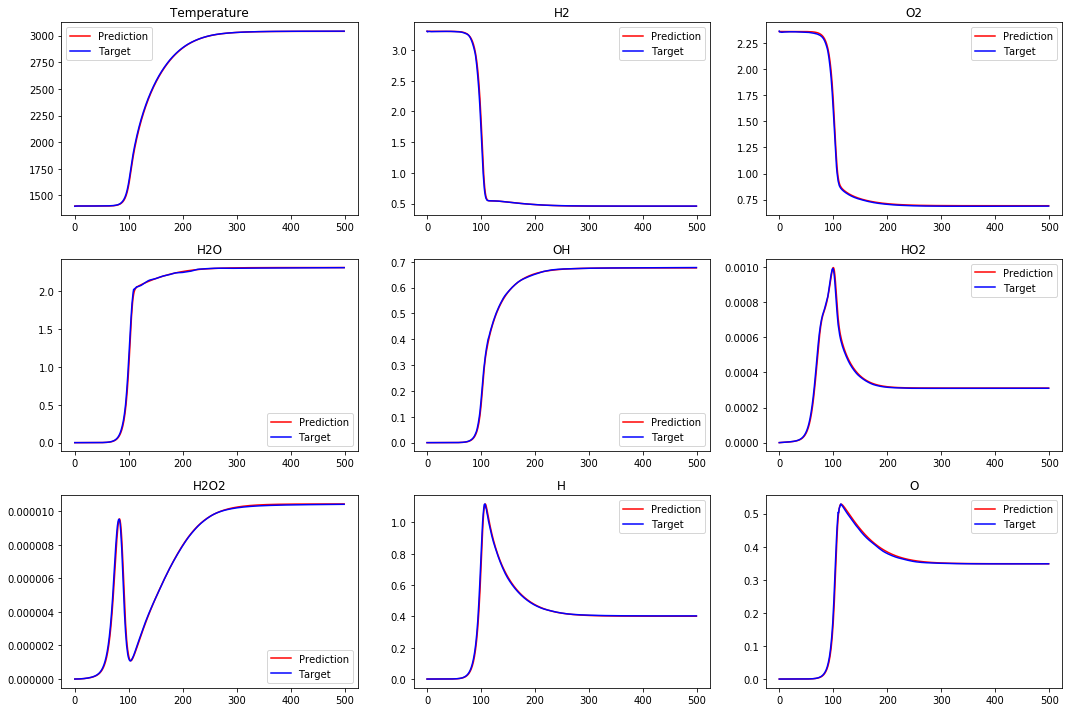

In [41]:
inv_validation = inverse_transform_data(torch.tensor(validation[:, :]), train_set.coeffs)
inv_prediction = inverse_transform_data(prediction[:, :], train_set.coeffs)
plot_errors(inv_validation, inv_prediction, nsteps=500, NETWORK_NAME=NETWORK_NAME, show=True)
print(((inv_validation[1:] - inv_prediction)**2).mean(axis=0), np.abs(inv_validation[1:] - inv_prediction).mean(axis=0))
plot_errors(inv_validation, inv_prediction, nsteps=500, NETWORK_NAME=NETWORK_NAME, show=False)

mean MSE:	0.00010323076	std MSE:	0.00033500293
mean MAE:	0.004193725	std MAE:	0.003922005


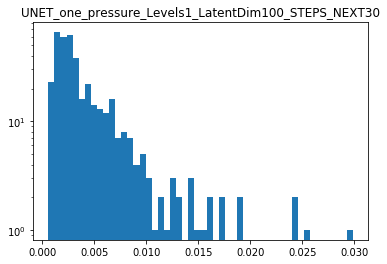

In [6]:
Validation = torch.FloatTensor(valid_set.data).to(device)
X0 = torch.FloatTensor(valid_set.data[:, 0, :]).to(device).unsqueeze(1)
N_steps = Validation.shape[1] - 1
Prediction_future = model.forward_several_steps_and_save(X0, t_next=N_steps).squeeze().cpu().detach().numpy()
#Prediction_future = predict_on_many_steps(model=model, X0=X0, N_steps=N_steps)
Validation = Validation.squeeze().cpu().detach().numpy()

MSE_error = ((Prediction_future - Validation[:, 1:])**2).mean(axis=(1,2))
MAE_error = (np.abs(Prediction_future - Validation[:, 1:])).mean(axis=(1,2))
print("mean MSE:", MSE_error.mean(), "std MSE:", MSE_error.std(), sep='\t')
print("mean MAE:", MAE_error.mean(), "std MAE:", MAE_error.std(), sep='\t')
#plt.plot(sorted(MSE_error), 'o')
plt.hist(sorted(MAE_error), bins=50)
plt.yscale('log')
plt.title(NETWORK_NAME)
plt.show()


In [7]:
ii = np.argsort(MAE_error)[::-1]
print('bad:', ii[:10], MAE_error[ii[:10]])
print('best:', ii[-10:], MAE_error[ii[-10:]])

bad: [288  37 348  48 140 335 290  57 398 180] [0.02983357 0.02520415 0.02411413 0.02410754 0.01906675 0.01888504
 0.01751801 0.01749666 0.01594596 0.0158894 ]
best: [ 30 107  25 232  90 343 356 386 214 112] [0.00094391 0.00092184 0.00091837 0.00090632 0.0008953  0.00085436
 0.00079533 0.0007712  0.00073643 0.00055638]


constant_approximation MSE:	 0.0024585952
constant_approximation MAE:	 0.003657514
предсказание нейронной сети на один шаг вперёд:
MSE:	 7.0355536e-06
MAE:	 0.0012417159
предсказание нейронной сети на много шагов вперёд:
MSE:	 0.0014273835
MAE:	 0.02411397


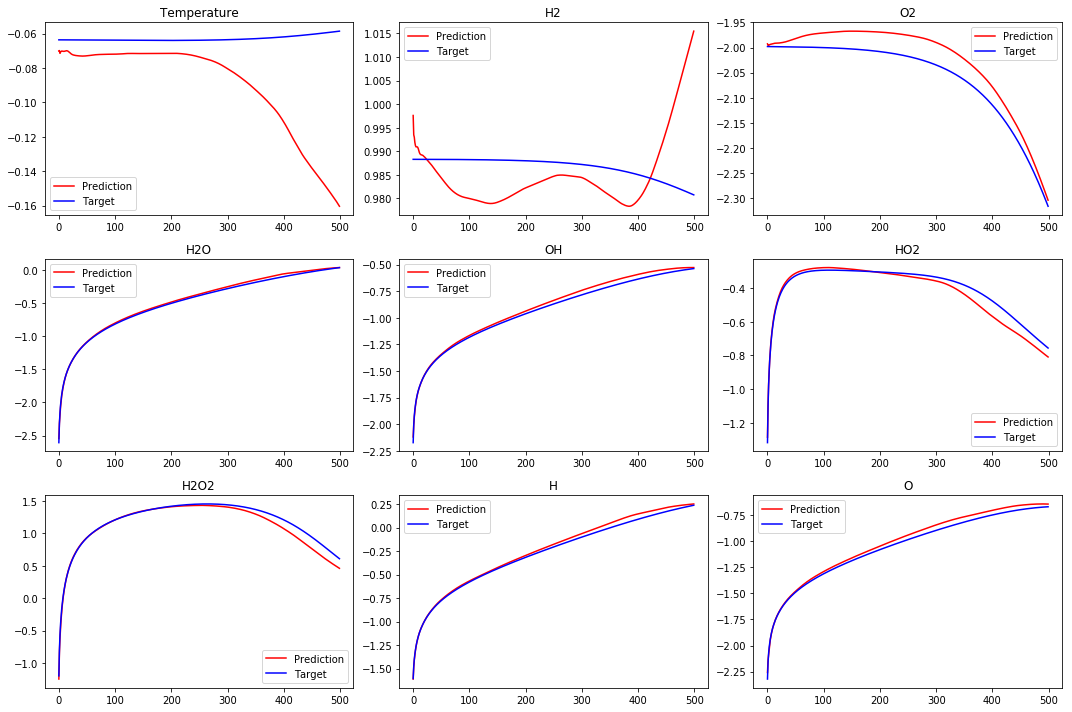

In [8]:
prediction, validation = validate_prediction(model, STEPS_PREV, valid_set, 348, device, NETWORK_NAME, nsteps=500, show=True)

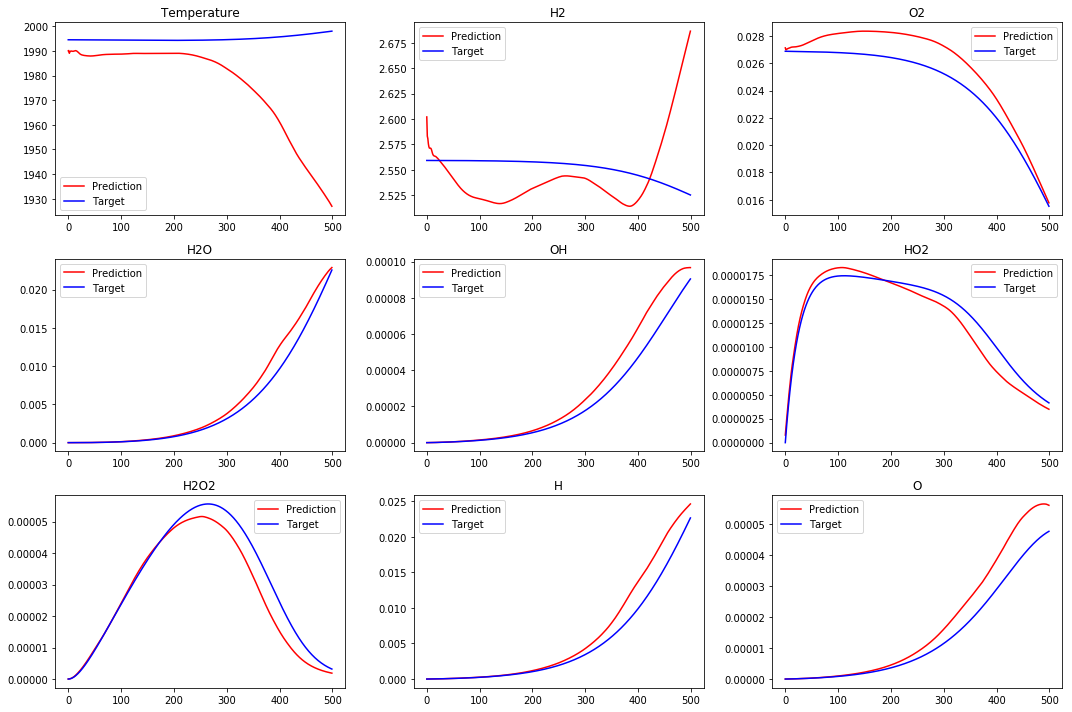

tensor([7.1896e+02, 1.8354e-03, 2.3125e-06, 1.5665e-06, 7.5900e-11, 1.5225e-12,
        2.3331e-11, 3.7258e-06, 3.5685e-11, 0.0000e+00, 0.0000e+00]) tensor([1.8661e+01, 3.1879e-02, 1.4162e-03, 7.9388e-04, 5.8611e-06, 1.0190e-06,
        3.4960e-06, 1.2173e-03, 4.1296e-06, 0.0000e+00, 0.0000e+00])


In [9]:
inv_validation = inverse_transform_data(torch.tensor(validation[:, :]), train_set.coeffs)
inv_prediction = inverse_transform_data(prediction[:, :], train_set.coeffs)
plot_errors(inv_prediction, inv_validation, nsteps=500, NETWORK_NAME=NETWORK_NAME, show=True)
print(((inv_validation[1:] - inv_prediction)**2).mean(axis=0), np.abs(inv_validation[1:] - inv_prediction).mean(axis=0))

In [10]:
import pandas as pd
df = pd.DataFrame(inverse_transform_data(train_set.data, train_set.coeffs).reshape(-1,11))
df.columns = ['T', 'H2', 'O2', 'H2O', 'OH', 'HO2', 'H2O2', 'H', 'O', 'N2', 'Ar']
df.describe()

,T,H2,O2,H2O,OH,HO2,H2O2,H,O,N2,Ar
count,4.008000e+06,4.008000e+06,4.008000e+06,4.008000e+06,4.008000e+06,4.008000e+06,4.008000e+06,4.008000e+06,4.008000e+06,4.008000e+06,4.008000e+06
mean,2.038909e+03,1.284154e+00,1.736104e+00,8.444875e-01,2.199144e-01,2.483877e-04,3.466085e-06,2.120454e-01,1.670666e-01,1.810167e+00,1.809371e+00
std,6.979149e+02,1.570962e+00,1.452733e+00,8.356475e-01,2.465837e-01,3.135352e-04,5.184224e-06,2.688367e-01,1.718147e-01,1.149606e+00,1.144484e+00
min,1.000066e+03,1.437736e-04,5.274594e-07,0.000000e+00,0.000000e+00,1.776357e-25,0.000000e+00,0.000000e+00,0.000000e+00,2.262673e-04,1.423946e-03
25%,1.344311e+03,1.366253e-01,5.426614e-01,3.289385e-04,3.394169e-05,1.063203e-05,8.184840e-08,2.108711e-04,4.743090e-05,9.637169e-01,9.511723e-01
50%,2.021424e+03,5.029516e-01,1.431578e+00,7.266969e-01,1.260569e-01,1.765791e-04,1.254945e-06,9.067156e-02,1.386185e-01,1.694693e+00,1.689481e+00
75%,2.718122e+03,2.084565e+00,2.609338e+00,1.497434e+00,4.026917e-01,3.557815e-04,5.195744e-06,3.491780e-01,3.022960e-01,2.466371e+00,2.466009e+00
max,3.191209e+03,9.932433e+00,8.401201e+00,4.187493e+00,1.378855e+00,3.918404e-03,1.034398e-04,2.380229e+00,1.082311e+00,8.510886e+00,8.505737e+00


In [11]:
df = df.drop(df[df['OH'] == 0].index)

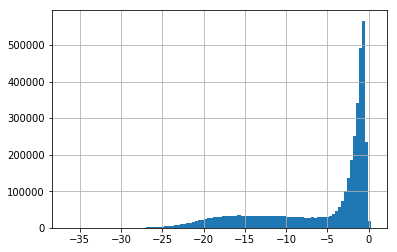

In [12]:
df['OH_log'] = df['OH'].apply(np.log)
df['OH_log'].hist(bins=100)

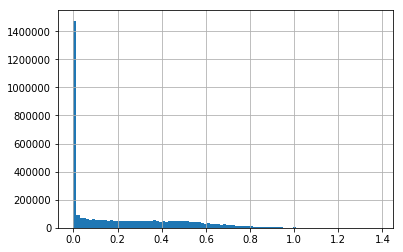

In [13]:
df['OH'].hist(bins=100)

In [40]:
train_set.data.shape

(8000, 501, 11)

In [41]:
train_set.coeffs

{'mean': array([2.03890895e+03, 1.28415363e+00, 1.73610397e+00, 8.44487486e-01,
        2.19914446e-01, 2.48387670e-04, 3.46608496e-06, 2.12045387e-01,
        1.67066603e-01, 1.81016724e+00, 1.80937089e+00]),
 'std': array([6.97914850e+02, 1.57096207e+00, 1.45273249e+00, 8.35647414e-01,
        2.46583695e-01, 3.13535140e-04, 5.18422343e-06, 2.68836691e-01,
        1.71814686e-01, 1.14960541e+00, 1.14448386e+00]),
 'log_mean': array([30.58141709, 22.20380559, 22.88465689, 19.04504139, 17.25762092,
        12.97928629,  8.26193804, 17.9280893 , 17.26878947, 23.32705401,
        23.32353   ]),
 'log_std': array([0.36884395, 1.78264805, 1.73934903, 6.2332109 , 6.57879971,
        3.11642998, 3.41329197, 5.55488908, 6.25350916, 0.94117832,
        0.94909018])}

In [42]:
train_starts = train_set.data[:, 0, :]
train_starts.shape

(8000, 11)

In [21]:
# valid_set
# bad: [288  37 348  48 140 335 290  57 398 180]
# best: [ 30 107  25 232  90 343 356 386 214 112]

In [22]:
valid_starts = valid_set.data[:, 0, :]

In [57]:
bad = ii[:10]#[288,37,348,48,140,335,290,57,398,180]
best = ii[-10:]#[ 30,107,25,232,90,343,356,386,214,112]


In [63]:
MAE_error[ii]

array([0.02983357, 0.02520415, 0.02411413, 0.02410754, 0.01906675,
       0.01888504, 0.01751801, 0.01749666, 0.01594596, 0.0158894 ,
       0.01529006, 0.01485239, 0.01449854, 0.01427066, 0.01408597,
       0.01336122, 0.01291471, 0.01269555, 0.01263468, 0.01253245,
       0.01192857, 0.01127222, 0.01109801, 0.01080729, 0.0104616 ,
       0.01029248, 0.01000288, 0.00983957, 0.00972928, 0.00958371,
       0.00953524, 0.0093545 , 0.00930669, 0.00921936, 0.00920108,
       0.00893201, 0.00870086, 0.00865824, 0.00853294, 0.00853102,
       0.00844621, 0.00825532, 0.00823758, 0.00815851, 0.00813264,
       0.00805138, 0.00803318, 0.00799839, 0.00787641, 0.00775323,
       0.00774746, 0.0075666 , 0.00753607, 0.00750469, 0.00718043,
       0.00714197, 0.00709821, 0.00704195, 0.00692255, 0.00692001,
       0.0068696 , 0.00683067, 0.00680023, 0.00677517, 0.00676126,
       0.00674435, 0.00665755, 0.00665722, 0.00664015, 0.00662528,
       0.0065613 , 0.00649287, 0.00648361, 0.00641812, 0.00624

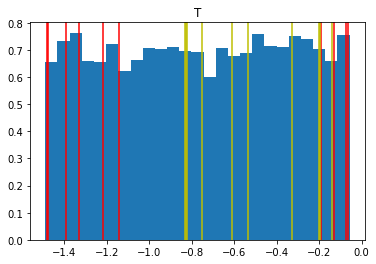

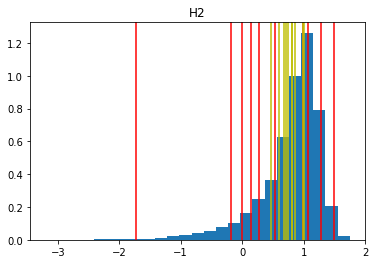

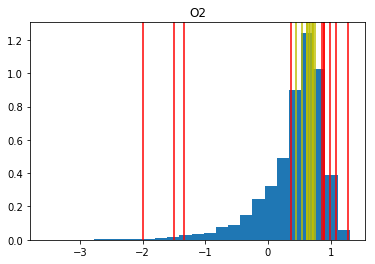

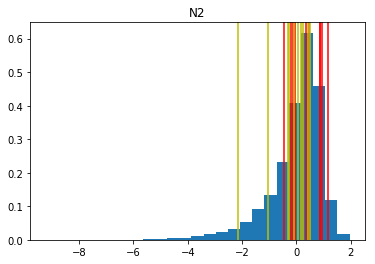

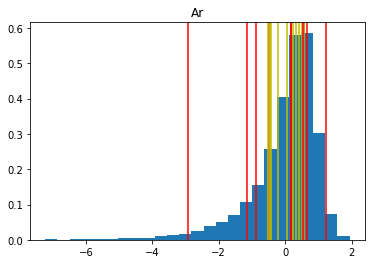

In [69]:
names = ['T', 'H2', 'O2', 'H2O', 'OH', 'HO2', 'H2O2', 'H', 'O', 'N2', 'Ar']
for i in [0,1,2,9,10]:
    plt.hist(train_starts[:,i], bins=25, density=True)
    plt.title(names[i])
    
    for k in range(len(bad)):
        plt.axvline(x=valid_starts[bad[k], i], color='r')
        plt.axvline(x=valid_starts[best[k], i], color='y')
        
    #plt.plot(valid_starts[ii, i], 50*MAE_error[ii], 'g*')
    plt.show()
    #print('bad:', *[valid_starts[k, i] for k in bad])
    #print('best:', *[valid_starts[k, i] for k in best])

In [44]:
a = np.load('data/train_set.npy')

In [45]:
a.shape

(8000, 501, 28)

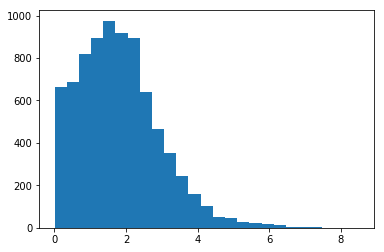

In [52]:
x = a[:, 0, 11]#np.random.rand(10000) * 20
plt.hist(x, bins=25)
plt.show()

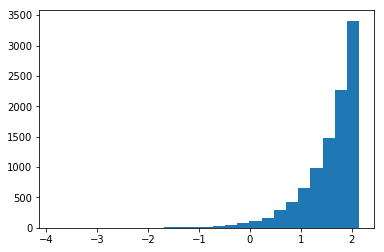

In [39]:
y = (np.log(1 + x * 1e10) - 22.20380559) / 1.78264805
plt.hist(y, bins=25)
plt.show()

In [28]:
train_set.coeffs

{'mean': array([2.03890895e+03, 1.28415363e+00, 1.73610397e+00, 8.44487486e-01,
        2.19914446e-01, 2.48387670e-04, 3.46608496e-06, 2.12045387e-01,
        1.67066603e-01, 1.81016724e+00, 1.80937089e+00]),
 'std': array([6.97914850e+02, 1.57096207e+00, 1.45273249e+00, 8.35647414e-01,
        2.46583695e-01, 3.13535140e-04, 5.18422343e-06, 2.68836691e-01,
        1.71814686e-01, 1.14960541e+00, 1.14448386e+00]),
 'log_mean': array([30.58141709, 22.20380559, 22.88465689, 19.04504139, 17.25762092,
        12.97928629,  8.26193804, 17.9280893 , 17.26878947, 23.32705401,
        23.32353   ]),
 'log_std': array([0.36884395, 1.78264805, 1.73934903, 6.2332109 , 6.57879971,
        3.11642998, 3.41329197, 5.55488908, 6.25350916, 0.94117832,
        0.94909018])}

In [29]:
np.log(1e10)

23.025850929940457

In [12]:
# обучение сети на одну эпоху
def process_one_epoch(model, loader, optimizer, device, coeffs, is_train=False,
                      is_LO_LH_compute=True, is_LO_LH_active=False, dL = 0.001
                      ):
    if is_train:
        model.train()
    else:
        model.eval()

    loss_record = {'MSE_1': [], 'MSE_t': [], 'MSE': [], 'LH': [], 'LO': [], 'tot': []}

    # weights = torch.FloatTensor(1 / (1 + np.arange(model.t_next))).to(device)

    with torch.set_grad_enabled(is_train):
        for input_data, target in tqdm(loader):
            input_data = input_data.to(device)
            target = target.to(device)
            predicted_one_step = model(input_data)
            # predicted_several_step = model.forward_several_steps(input_data, model.t_next)
            several_steps_predictions = model.forward_several_steps_and_save(input_data, model.t_next)

            # среднекваратичная ошибка предсказания
            mse_one_step = MSE(predicted_one_step, target[:, :1, :])
            # mse_several_step = MSE(predicted_several_step, target[:,-1:,:])
            mse_several_step = compute_weighted_loss_on_several_predictions(several_steps_predictions,
                                                                            target,
                                                                            device,
                                                                            weights=None,  # constant weights
                                                                            loss=MSE)
            mse = mse_several_step
            # полная функция ошибки
            loss = mse + 0  # + lh + lo

            if is_LO_LH_compute or is_LO_LH_active:
                # проверка сохранения числа атомов водорода и кислорода
                X = inverse_transform_data(several_steps_predictions, coeffs)
                Y = inverse_transform_data(target, coeffs)
                lo = compute_weighted_loss_on_several_predictions(X, Y, device, loss=LO)
                lh = compute_weighted_loss_on_several_predictions(X, Y, device, loss=LH)
                if is_LO_LH_active:
                    loss += dL * (lh + lo)

            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            loss_record['MSE_1'].append(mse_one_step.item())
            loss_record['MSE_t'].append(mse_several_step.item())
            loss_record['MSE'].append(mse.item())
            loss_record['tot'].append(loss.item())
            if is_LO_LH_compute or is_LO_LH_active:
                loss_record['LH'].append(lh.item())
                loss_record['LO'].append(lo.item())

    mean_loss_record = {key: np.mean(loss_record[key]) for key in loss_record.keys()}
    return mean_loss_record


## Обучение с LO и LH

In [13]:
def combine_two_dicts_of_list(dlist1, dlist2):
    d = {key : dlist1[key] + dlist2[key] for key in dlist1.keys()}
    return d

def append_dict_to_dict_of_list(dlist1, dict2):
    d = {key : dlist1[key] + [dict2[key]] for key in dlist1.keys()}
    return d

train_loss_history = {'MSE_1':[], 'MSE_t':[], 'MSE':[], 'LH':[], 'LO':[], 'tot':[]}
test_loss_history = {'MSE_1':[], 'MSE_t':[], 'MSE':[], 'LH':[], 'LO':[], 'tot':[]}

# оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.1)

coeffs = {name : torch.FloatTensor(coef).to(device) for name, coef in train_set.coeffs.items()}
for epoch in range(0, EPOCHS_NUM):#, 2 * EPOCHS_NUM):
    # обучение сети
    mean_loss_record = process_one_epoch(model=model, loader=train_loader, optimizer=optimizer,
                                         device=device, coeffs=coeffs, is_train=True, 
                                         is_LO_LH_compute=False, is_LO_LH_active=False)
    train_loss_history = append_dict_to_dict_of_list(train_loss_history, mean_loss_record)
    
    # проверка на тестовой выборке
    mean_loss_record = process_one_epoch(model=model, loader=test_loader, optimizer=None,
                                         device=device, coeffs=coeffs, is_train=False, 
                                         is_LO_LH_compute=True, is_LO_LH_active=False)
    test_loss_history = append_dict_to_dict_of_list(test_loss_history, mean_loss_record)
    
    lr_scheduler.step(test_loss_history['tot'][-1])
    
    # вывод значений ошибок каждую эпоху
    print(f'epoch {epoch}', 
                 '\n train:', ', '.join([f'{v[0]} {v[1][-1]:0.8f}' for v in train_loss_history.items()]),
                 '\n test: ', ', '.join([f'{v[0]} {v[1][-1]:0.8f}' for v in test_loss_history.items()]))
    
    # сохранение результатов и обученной модели в файл
    if not os.path.isdir('./checkpoints'):
        os.makedirs('./checkpoints')
    if not os.path.isdir('./checkpoints/{}'.format(NETWORK_NAME)):
        os.makedirs('./checkpoints/{}'.format(NETWORK_NAME))
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss_history,
                'test_loss': test_loss_history
                }, './checkpoints/{}/{}_epoch_{}_LH_LO.pth'.format(NETWORK_NAME, NETWORK_NAME, epoch))

  0%|          | 0/7344 [00:00<?, ?it/s]

C:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 0 
 train: MSE_1 0.05283374, MSE_t 32.00547964, MSE 32.00547964, LH nan, LO nan, tot 32.00547964 
 test:  MSE_1 0.00931666, MSE_t 0.05033467, MSE 0.05033467, LH 1.85812597, LO 1.59644487, tot 0.05033467


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 1 
 train: MSE_1 0.00468631, MSE_t 0.01839625, MSE 0.01839625, LH nan, LO nan, tot 0.01839625 
 test:  MSE_1 0.00319057, MSE_t 0.00624484, MSE 0.00624484, LH 0.56590549, LO 0.42591610, tot 0.00624484


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 2 
 train: MSE_1 0.00244006, MSE_t 0.00360300, MSE 0.00360300, LH nan, LO nan, tot 0.00360300 
 test:  MSE_1 0.00201502, MSE_t 0.00248703, MSE 0.00248703, LH 0.26537579, LO 0.30746348, tot 0.00248703


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 3 
 train: MSE_1 0.00138370, MSE_t 0.00158291, MSE 0.00158291, LH nan, LO nan, tot 0.00158291 
 test:  MSE_1 0.00057510, MSE_t 0.00103718, MSE 0.00103718, LH 0.23474606, LO 0.18868468, tot 0.00103718


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 4 
 train: MSE_1 0.00022224, MSE_t 0.00071639, MSE 0.00071639, LH nan, LO nan, tot 0.00071639 
 test:  MSE_1 0.00011295, MSE_t 0.00076789, MSE 0.00076789, LH 0.18612491, LO 0.13020744, tot 0.00076789


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 5 
 train: MSE_1 0.00008709, MSE_t 0.00041107, MSE 0.00041107, LH nan, LO nan, tot 0.00041107 
 test:  MSE_1 0.00024282, MSE_t 0.00091644, MSE 0.00091644, LH 0.30045383, LO 0.18464060, tot 0.00091644


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 6 
 train: MSE_1 0.00005652, MSE_t 0.00026155, MSE 0.00026155, LH nan, LO nan, tot 0.00026155 
 test:  MSE_1 0.00003918, MSE_t 0.00022691, MSE 0.00022691, LH 0.10604421, LO 0.09215505, tot 0.00022691


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 7 
 train: MSE_1 0.00003886, MSE_t 0.00018100, MSE 0.00018100, LH nan, LO nan, tot 0.00018100 
 test:  MSE_1 0.00002836, MSE_t 0.00007778, MSE 0.00007778, LH 0.06452611, LO 0.05354789, tot 0.00007778


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 8 
 train: MSE_1 0.00002881, MSE_t 0.00012200, MSE 0.00012200, LH nan, LO nan, tot 0.00012200 
 test:  MSE_1 0.00002296, MSE_t 0.00008348, MSE 0.00008348, LH 0.06393035, LO 0.05302093, tot 0.00008348


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 9 
 train: MSE_1 0.00002411, MSE_t 0.00008877, MSE 0.00008877, LH nan, LO nan, tot 0.00008877 
 test:  MSE_1 0.00002056, MSE_t 0.00005232, MSE 0.00005232, LH 0.06263822, LO 0.04250858, tot 0.00005232


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 10 
 train: MSE_1 0.00001910, MSE_t 0.00006850, MSE 0.00006850, LH nan, LO nan, tot 0.00006850 
 test:  MSE_1 0.00001737, MSE_t 0.00007331, MSE 0.00007331, LH 0.05524585, LO 0.03840462, tot 0.00007331


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 11 
 train: MSE_1 0.00001613, MSE_t 0.00005770, MSE 0.00005770, LH nan, LO nan, tot 0.00005770 
 test:  MSE_1 0.00001428, MSE_t 0.00003507, MSE 0.00003507, LH 0.03965700, LO 0.03215150, tot 0.00003507


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 12 
 train: MSE_1 0.00001466, MSE_t 0.00004966, MSE 0.00004966, LH nan, LO nan, tot 0.00004966 
 test:  MSE_1 0.00000954, MSE_t 0.00002658, MSE 0.00002658, LH 0.05015198, LO 0.03735009, tot 0.00002658


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 13 
 train: MSE_1 0.00001337, MSE_t 0.00004569, MSE 0.00004569, LH nan, LO nan, tot 0.00004569 
 test:  MSE_1 0.00000832, MSE_t 0.00001233, MSE 0.00001233, LH 0.02616094, LO 0.01559022, tot 0.00001233


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 14 
 train: MSE_1 0.00001275, MSE_t 0.00004706, MSE 0.00004706, LH nan, LO nan, tot 0.00004706 
 test:  MSE_1 0.00001031, MSE_t 0.00002541, MSE 0.00002541, LH 0.04864905, LO 0.02261840, tot 0.00002541


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 15 
 train: MSE_1 0.00001150, MSE_t 0.00004012, MSE 0.00004012, LH nan, LO nan, tot 0.00004012 
 test:  MSE_1 0.00000649, MSE_t 0.00001111, MSE 0.00001111, LH 0.02143475, LO 0.01780814, tot 0.00001111


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 16 
 train: MSE_1 0.00001080, MSE_t 0.00003752, MSE 0.00003752, LH nan, LO nan, tot 0.00003752 
 test:  MSE_1 0.00000883, MSE_t 0.00002836, MSE 0.00002836, LH 0.04882261, LO 0.03272167, tot 0.00002836


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 17 
 train: MSE_1 0.00001036, MSE_t 0.00003726, MSE 0.00003726, LH nan, LO nan, tot 0.00003726 
 test:  MSE_1 0.00000662, MSE_t 0.00001294, MSE 0.00001294, LH 0.02672233, LO 0.01580226, tot 0.00001294


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 18 
 train: MSE_1 0.00000992, MSE_t 0.00003414, MSE 0.00003414, LH nan, LO nan, tot 0.00003414 
 test:  MSE_1 0.00000937, MSE_t 0.00003848, MSE 0.00003848, LH 0.05172564, LO 0.02796880, tot 0.00003848


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 19 
 train: MSE_1 0.00000928, MSE_t 0.00003072, MSE 0.00003072, LH nan, LO nan, tot 0.00003072 
 test:  MSE_1 0.00000639, MSE_t 0.00002304, MSE 0.00002304, LH 0.04486250, LO 0.03181436, tot 0.00002304


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 20 
 train: MSE_1 0.00000999, MSE_t 0.00003570, MSE 0.00003570, LH nan, LO nan, tot 0.00003570 
 test:  MSE_1 0.00000650, MSE_t 0.00001211, MSE 0.00001211, LH 0.02180134, LO 0.01532807, tot 0.00001211


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

Epoch    22: reducing learning rate of group 0 to 1.0000e-04.
epoch 21 
 train: MSE_1 0.00000712, MSE_t 0.00002330, MSE 0.00002330, LH nan, LO nan, tot 0.00002330 
 test:  MSE_1 0.00000606, MSE_t 0.00003391, MSE 0.00003391, LH 0.03241309, LO 0.02376580, tot 0.00003391


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 22 
 train: MSE_1 0.00000277, MSE_t 0.00000390, MSE 0.00000390, LH nan, LO nan, tot 0.00000390 
 test:  MSE_1 0.00000254, MSE_t 0.00000463, MSE 0.00000463, LH 0.01340539, LO 0.00852711, tot 0.00000463


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 23 
 train: MSE_1 0.00000223, MSE_t 0.00000356, MSE 0.00000356, LH nan, LO nan, tot 0.00000356 
 test:  MSE_1 0.00000217, MSE_t 0.00000406, MSE 0.00000406, LH 0.01312918, LO 0.00779593, tot 0.00000406


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 24 
 train: MSE_1 0.00000201, MSE_t 0.00000329, MSE 0.00000329, LH nan, LO nan, tot 0.00000329 
 test:  MSE_1 0.00000200, MSE_t 0.00000395, MSE 0.00000395, LH 0.01286579, LO 0.00776535, tot 0.00000395


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 25 
 train: MSE_1 0.00000186, MSE_t 0.00000310, MSE 0.00000310, LH nan, LO nan, tot 0.00000310 
 test:  MSE_1 0.00000192, MSE_t 0.00000371, MSE 0.00000371, LH 0.01236961, LO 0.00756643, tot 0.00000371


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 26 
 train: MSE_1 0.00000175, MSE_t 0.00000296, MSE 0.00000296, LH nan, LO nan, tot 0.00000296 
 test:  MSE_1 0.00000178, MSE_t 0.00000399, MSE 0.00000399, LH 0.01197939, LO 0.00792339, tot 0.00000399


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 27 
 train: MSE_1 0.00000165, MSE_t 0.00000282, MSE 0.00000282, LH nan, LO nan, tot 0.00000282 
 test:  MSE_1 0.00000175, MSE_t 0.00000378, MSE 0.00000378, LH 0.01199020, LO 0.00805221, tot 0.00000378


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 28 
 train: MSE_1 0.00000158, MSE_t 0.00000272, MSE 0.00000272, LH nan, LO nan, tot 0.00000272 
 test:  MSE_1 0.00000162, MSE_t 0.00000340, MSE 0.00000340, LH 0.01120484, LO 0.00718250, tot 0.00000340


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 29 
 train: MSE_1 0.00000151, MSE_t 0.00000265, MSE 0.00000265, LH nan, LO nan, tot 0.00000265 
 test:  MSE_1 0.00000160, MSE_t 0.00000363, MSE 0.00000363, LH 0.01394538, LO 0.00759368, tot 0.00000363


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 30 
 train: MSE_1 0.00000145, MSE_t 0.00000256, MSE 0.00000256, LH nan, LO nan, tot 0.00000256 
 test:  MSE_1 0.00000147, MSE_t 0.00000358, MSE 0.00000358, LH 0.01143815, LO 0.00681912, tot 0.00000358


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 31 
 train: MSE_1 0.00000140, MSE_t 0.00000248, MSE 0.00000248, LH nan, LO nan, tot 0.00000248 
 test:  MSE_1 0.00000144, MSE_t 0.00000305, MSE 0.00000305, LH 0.01285703, LO 0.00852217, tot 0.00000305


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 32 
 train: MSE_1 0.00000135, MSE_t 0.00000243, MSE 0.00000243, LH nan, LO nan, tot 0.00000243 
 test:  MSE_1 0.00000143, MSE_t 0.00000345, MSE 0.00000345, LH 0.01033554, LO 0.00710708, tot 0.00000345


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 33 
 train: MSE_1 0.00000131, MSE_t 0.00000238, MSE 0.00000238, LH nan, LO nan, tot 0.00000238 
 test:  MSE_1 0.00000137, MSE_t 0.00000294, MSE 0.00000294, LH 0.01036509, LO 0.00672363, tot 0.00000294


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 34 
 train: MSE_1 0.00000128, MSE_t 0.00000231, MSE 0.00000231, LH nan, LO nan, tot 0.00000231 
 test:  MSE_1 0.00000131, MSE_t 0.00000309, MSE 0.00000309, LH 0.01028691, LO 0.00723795, tot 0.00000309


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 35 
 train: MSE_1 0.00000124, MSE_t 0.00000228, MSE 0.00000228, LH nan, LO nan, tot 0.00000228 
 test:  MSE_1 0.00000126, MSE_t 0.00000267, MSE 0.00000267, LH 0.01004142, LO 0.00603806, tot 0.00000267


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 36 
 train: MSE_1 0.00000121, MSE_t 0.00000224, MSE 0.00000224, LH nan, LO nan, tot 0.00000224 
 test:  MSE_1 0.00000126, MSE_t 0.00000305, MSE 0.00000305, LH 0.01151704, LO 0.00631552, tot 0.00000305


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 37 
 train: MSE_1 0.00000118, MSE_t 0.00000221, MSE 0.00000221, LH nan, LO nan, tot 0.00000221 
 test:  MSE_1 0.00000124, MSE_t 0.00000270, MSE 0.00000270, LH 0.00952549, LO 0.00610267, tot 0.00000270


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 38 
 train: MSE_1 0.00000116, MSE_t 0.00000217, MSE 0.00000217, LH nan, LO nan, tot 0.00000217 
 test:  MSE_1 0.00000122, MSE_t 0.00000265, MSE 0.00000265, LH 0.01050897, LO 0.00594441, tot 0.00000265


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 39 
 train: MSE_1 0.00000114, MSE_t 0.00000215, MSE 0.00000215, LH nan, LO nan, tot 0.00000215 
 test:  MSE_1 0.00000130, MSE_t 0.00000395, MSE 0.00000395, LH 0.01122570, LO 0.00667431, tot 0.00000395


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 40 
 train: MSE_1 0.00000111, MSE_t 0.00000210, MSE 0.00000210, LH nan, LO nan, tot 0.00000210 
 test:  MSE_1 0.00000112, MSE_t 0.00000273, MSE 0.00000273, LH 0.00966249, LO 0.00642362, tot 0.00000273


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 41 
 train: MSE_1 0.00000110, MSE_t 0.00000208, MSE 0.00000208, LH nan, LO nan, tot 0.00000208 
 test:  MSE_1 0.00000110, MSE_t 0.00000257, MSE 0.00000257, LH 0.01050606, LO 0.00736511, tot 0.00000257


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 42 
 train: MSE_1 0.00000107, MSE_t 0.00000204, MSE 0.00000204, LH nan, LO nan, tot 0.00000204 
 test:  MSE_1 0.00000110, MSE_t 0.00000253, MSE 0.00000253, LH 0.00932433, LO 0.00567103, tot 0.00000253


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 43 
 train: MSE_1 0.00000106, MSE_t 0.00000202, MSE 0.00000202, LH nan, LO nan, tot 0.00000202 
 test:  MSE_1 0.00000110, MSE_t 0.00000286, MSE 0.00000286, LH 0.00920202, LO 0.00557508, tot 0.00000286


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 44 
 train: MSE_1 0.00000104, MSE_t 0.00000201, MSE 0.00000201, LH nan, LO nan, tot 0.00000201 
 test:  MSE_1 0.00000105, MSE_t 0.00000249, MSE 0.00000249, LH 0.00952181, LO 0.00568850, tot 0.00000249


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 45 
 train: MSE_1 0.00000102, MSE_t 0.00000200, MSE 0.00000200, LH nan, LO nan, tot 0.00000200 
 test:  MSE_1 0.00000104, MSE_t 0.00000236, MSE 0.00000236, LH 0.00896898, LO 0.00570427, tot 0.00000236


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 46 
 train: MSE_1 0.00000101, MSE_t 0.00000197, MSE 0.00000197, LH nan, LO nan, tot 0.00000197 
 test:  MSE_1 0.00000107, MSE_t 0.00000277, MSE 0.00000277, LH 0.01105680, LO 0.00852605, tot 0.00000277


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 47 
 train: MSE_1 0.00000099, MSE_t 0.00000194, MSE 0.00000194, LH nan, LO nan, tot 0.00000194 
 test:  MSE_1 0.00000099, MSE_t 0.00000235, MSE 0.00000235, LH 0.00990976, LO 0.00554336, tot 0.00000235


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 48 
 train: MSE_1 0.00000098, MSE_t 0.00000193, MSE 0.00000193, LH nan, LO nan, tot 0.00000193 
 test:  MSE_1 0.00000098, MSE_t 0.00000245, MSE 0.00000245, LH 0.00943993, LO 0.00606726, tot 0.00000245


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 49 
 train: MSE_1 0.00000096, MSE_t 0.00000189, MSE 0.00000189, LH nan, LO nan, tot 0.00000189 
 test:  MSE_1 0.00000113, MSE_t 0.00000358, MSE 0.00000358, LH 0.01333621, LO 0.00649451, tot 0.00000358


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 50 
 train: MSE_1 0.00000095, MSE_t 0.00000190, MSE 0.00000190, LH nan, LO nan, tot 0.00000190 
 test:  MSE_1 0.00000107, MSE_t 0.00000388, MSE 0.00000388, LH 0.01070124, LO 0.00664389, tot 0.00000388


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 51 
 train: MSE_1 0.00000094, MSE_t 0.00000186, MSE 0.00000186, LH nan, LO nan, tot 0.00000186 
 test:  MSE_1 0.00000099, MSE_t 0.00000245, MSE 0.00000245, LH 0.00821397, LO 0.00625502, tot 0.00000245


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 52 
 train: MSE_1 0.00000092, MSE_t 0.00000186, MSE 0.00000186, LH nan, LO nan, tot 0.00000186 
 test:  MSE_1 0.00000092, MSE_t 0.00000242, MSE 0.00000242, LH 0.00861999, LO 0.00564138, tot 0.00000242


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

Epoch    54: reducing learning rate of group 0 to 1.0000e-05.
epoch 53 
 train: MSE_1 0.00000092, MSE_t 0.00000184, MSE 0.00000184, LH nan, LO nan, tot 0.00000184 
 test:  MSE_1 0.00000111, MSE_t 0.00000281, MSE 0.00000281, LH 0.01426121, LO 0.00793937, tot 0.00000281


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 54 
 train: MSE_1 0.00000084, MSE_t 0.00000130, MSE 0.00000130, LH nan, LO nan, tot 0.00000130 
 test:  MSE_1 0.00000088, MSE_t 0.00000194, MSE 0.00000194, LH 0.00759024, LO 0.00477943, tot 0.00000194


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 55 
 train: MSE_1 0.00000083, MSE_t 0.00000130, MSE 0.00000130, LH nan, LO nan, tot 0.00000130 
 test:  MSE_1 0.00000087, MSE_t 0.00000193, MSE 0.00000193, LH 0.00743415, LO 0.00463462, tot 0.00000193


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 56 
 train: MSE_1 0.00000083, MSE_t 0.00000129, MSE 0.00000129, LH nan, LO nan, tot 0.00000129 
 test:  MSE_1 0.00000087, MSE_t 0.00000194, MSE 0.00000194, LH 0.00761336, LO 0.00470309, tot 0.00000194


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 57 
 train: MSE_1 0.00000082, MSE_t 0.00000129, MSE 0.00000129, LH nan, LO nan, tot 0.00000129 
 test:  MSE_1 0.00000086, MSE_t 0.00000193, MSE 0.00000193, LH 0.00737641, LO 0.00476204, tot 0.00000193


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 58 
 train: MSE_1 0.00000082, MSE_t 0.00000128, MSE 0.00000128, LH nan, LO nan, tot 0.00000128 
 test:  MSE_1 0.00000086, MSE_t 0.00000191, MSE 0.00000191, LH 0.00741307, LO 0.00462770, tot 0.00000191


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 59 
 train: MSE_1 0.00000081, MSE_t 0.00000128, MSE 0.00000128, LH nan, LO nan, tot 0.00000128 
 test:  MSE_1 0.00000085, MSE_t 0.00000191, MSE 0.00000191, LH 0.00751519, LO 0.00466123, tot 0.00000191


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 60 
 train: MSE_1 0.00000081, MSE_t 0.00000128, MSE 0.00000128, LH nan, LO nan, tot 0.00000128 
 test:  MSE_1 0.00000085, MSE_t 0.00000192, MSE 0.00000192, LH 0.00729011, LO 0.00458578, tot 0.00000192


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 61 
 train: MSE_1 0.00000081, MSE_t 0.00000127, MSE 0.00000127, LH nan, LO nan, tot 0.00000127 
 test:  MSE_1 0.00000084, MSE_t 0.00000192, MSE 0.00000192, LH 0.00734281, LO 0.00460550, tot 0.00000192


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 62 
 train: MSE_1 0.00000080, MSE_t 0.00000127, MSE 0.00000127, LH nan, LO nan, tot 0.00000127 
 test:  MSE_1 0.00000086, MSE_t 0.00000194, MSE 0.00000194, LH 0.00736688, LO 0.00468160, tot 0.00000194


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 63 
 train: MSE_1 0.00000080, MSE_t 0.00000126, MSE 0.00000126, LH nan, LO nan, tot 0.00000126 
 test:  MSE_1 0.00000084, MSE_t 0.00000189, MSE 0.00000189, LH 0.00736974, LO 0.00459464, tot 0.00000189


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 64 
 train: MSE_1 0.00000080, MSE_t 0.00000126, MSE 0.00000126, LH nan, LO nan, tot 0.00000126 
 test:  MSE_1 0.00000084, MSE_t 0.00000188, MSE 0.00000188, LH 0.00736187, LO 0.00458350, tot 0.00000188


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 65 
 train: MSE_1 0.00000079, MSE_t 0.00000126, MSE 0.00000126, LH nan, LO nan, tot 0.00000126 
 test:  MSE_1 0.00000083, MSE_t 0.00000188, MSE 0.00000188, LH 0.00747299, LO 0.00464367, tot 0.00000188


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 66 
 train: MSE_1 0.00000079, MSE_t 0.00000125, MSE 0.00000125, LH nan, LO nan, tot 0.00000125 
 test:  MSE_1 0.00000084, MSE_t 0.00000191, MSE 0.00000191, LH 0.00743449, LO 0.00462980, tot 0.00000191


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 67 
 train: MSE_1 0.00000079, MSE_t 0.00000125, MSE 0.00000125, LH nan, LO nan, tot 0.00000125 
 test:  MSE_1 0.00000083, MSE_t 0.00000188, MSE 0.00000188, LH 0.00735292, LO 0.00452252, tot 0.00000188


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 68 
 train: MSE_1 0.00000078, MSE_t 0.00000125, MSE 0.00000125, LH nan, LO nan, tot 0.00000125 
 test:  MSE_1 0.00000082, MSE_t 0.00000190, MSE 0.00000190, LH 0.00720976, LO 0.00453308, tot 0.00000190


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 69 
 train: MSE_1 0.00000078, MSE_t 0.00000124, MSE 0.00000124, LH nan, LO nan, tot 0.00000124 
 test:  MSE_1 0.00000082, MSE_t 0.00000188, MSE 0.00000188, LH 0.00738073, LO 0.00459605, tot 0.00000188


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 70 
 train: MSE_1 0.00000078, MSE_t 0.00000124, MSE 0.00000124, LH nan, LO nan, tot 0.00000124 
 test:  MSE_1 0.00000082, MSE_t 0.00000189, MSE 0.00000189, LH 0.00733408, LO 0.00452580, tot 0.00000189


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 71 
 train: MSE_1 0.00000078, MSE_t 0.00000124, MSE 0.00000124, LH nan, LO nan, tot 0.00000124 
 test:  MSE_1 0.00000083, MSE_t 0.00000185, MSE 0.00000185, LH 0.00721100, LO 0.00463552, tot 0.00000185


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 72 
 train: MSE_1 0.00000077, MSE_t 0.00000123, MSE 0.00000123, LH nan, LO nan, tot 0.00000123 
 test:  MSE_1 0.00000082, MSE_t 0.00000188, MSE 0.00000188, LH 0.00725006, LO 0.00450876, tot 0.00000188


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 73 
 train: MSE_1 0.00000077, MSE_t 0.00000123, MSE 0.00000123, LH nan, LO nan, tot 0.00000123 
 test:  MSE_1 0.00000082, MSE_t 0.00000186, MSE 0.00000186, LH 0.00752986, LO 0.00477895, tot 0.00000186


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 74 
 train: MSE_1 0.00000077, MSE_t 0.00000123, MSE 0.00000123, LH nan, LO nan, tot 0.00000123 
 test:  MSE_1 0.00000081, MSE_t 0.00000186, MSE 0.00000186, LH 0.00727142, LO 0.00455646, tot 0.00000186


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 75 
 train: MSE_1 0.00000077, MSE_t 0.00000123, MSE 0.00000123, LH nan, LO nan, tot 0.00000123 
 test:  MSE_1 0.00000081, MSE_t 0.00000187, MSE 0.00000187, LH 0.00717783, LO 0.00448543, tot 0.00000187


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 76 
 train: MSE_1 0.00000076, MSE_t 0.00000122, MSE 0.00000122, LH nan, LO nan, tot 0.00000122 
 test:  MSE_1 0.00000080, MSE_t 0.00000184, MSE 0.00000184, LH 0.00723505, LO 0.00455460, tot 0.00000184


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 77 
 train: MSE_1 0.00000076, MSE_t 0.00000122, MSE 0.00000122, LH nan, LO nan, tot 0.00000122 
 test:  MSE_1 0.00000081, MSE_t 0.00000189, MSE 0.00000189, LH 0.00721472, LO 0.00455767, tot 0.00000189


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 78 
 train: MSE_1 0.00000076, MSE_t 0.00000122, MSE 0.00000122, LH nan, LO nan, tot 0.00000122 
 test:  MSE_1 0.00000080, MSE_t 0.00000184, MSE 0.00000184, LH 0.00716152, LO 0.00446156, tot 0.00000184


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 79 
 train: MSE_1 0.00000076, MSE_t 0.00000121, MSE 0.00000121, LH nan, LO nan, tot 0.00000121 
 test:  MSE_1 0.00000080, MSE_t 0.00000184, MSE 0.00000184, LH 0.00730006, LO 0.00467507, tot 0.00000184


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 80 
 train: MSE_1 0.00000076, MSE_t 0.00000121, MSE 0.00000121, LH nan, LO nan, tot 0.00000121 
 test:  MSE_1 0.00000079, MSE_t 0.00000184, MSE 0.00000184, LH 0.00712219, LO 0.00447603, tot 0.00000184


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 81 
 train: MSE_1 0.00000075, MSE_t 0.00000121, MSE 0.00000121, LH nan, LO nan, tot 0.00000121 
 test:  MSE_1 0.00000080, MSE_t 0.00000185, MSE 0.00000185, LH 0.00713140, LO 0.00444294, tot 0.00000185


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 82 
 train: MSE_1 0.00000075, MSE_t 0.00000120, MSE 0.00000120, LH nan, LO nan, tot 0.00000120 
 test:  MSE_1 0.00000079, MSE_t 0.00000183, MSE 0.00000183, LH 0.00712086, LO 0.00452310, tot 0.00000183


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 83 
 train: MSE_1 0.00000075, MSE_t 0.00000120, MSE 0.00000120, LH nan, LO nan, tot 0.00000120 
 test:  MSE_1 0.00000079, MSE_t 0.00000182, MSE 0.00000182, LH 0.00710307, LO 0.00444801, tot 0.00000182


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 84 
 train: MSE_1 0.00000075, MSE_t 0.00000120, MSE 0.00000120, LH nan, LO nan, tot 0.00000120 
 test:  MSE_1 0.00000079, MSE_t 0.00000182, MSE 0.00000182, LH 0.00710224, LO 0.00439459, tot 0.00000182


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 85 
 train: MSE_1 0.00000074, MSE_t 0.00000120, MSE 0.00000120, LH nan, LO nan, tot 0.00000120 
 test:  MSE_1 0.00000078, MSE_t 0.00000183, MSE 0.00000183, LH 0.00706882, LO 0.00441979, tot 0.00000183


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 86 
 train: MSE_1 0.00000074, MSE_t 0.00000119, MSE 0.00000119, LH nan, LO nan, tot 0.00000119 
 test:  MSE_1 0.00000078, MSE_t 0.00000180, MSE 0.00000180, LH 0.00699014, LO 0.00433894, tot 0.00000180


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 87 
 train: MSE_1 0.00000074, MSE_t 0.00000119, MSE 0.00000119, LH nan, LO nan, tot 0.00000119 
 test:  MSE_1 0.00000078, MSE_t 0.00000182, MSE 0.00000182, LH 0.00715885, LO 0.00469076, tot 0.00000182


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 88 
 train: MSE_1 0.00000074, MSE_t 0.00000119, MSE 0.00000119, LH nan, LO nan, tot 0.00000119 
 test:  MSE_1 0.00000077, MSE_t 0.00000180, MSE 0.00000180, LH 0.00704457, LO 0.00443444, tot 0.00000180


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 89 
 train: MSE_1 0.00000073, MSE_t 0.00000118, MSE 0.00000118, LH nan, LO nan, tot 0.00000118 
 test:  MSE_1 0.00000077, MSE_t 0.00000180, MSE 0.00000180, LH 0.00707118, LO 0.00448910, tot 0.00000180


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 90 
 train: MSE_1 0.00000073, MSE_t 0.00000118, MSE 0.00000118, LH nan, LO nan, tot 0.00000118 
 test:  MSE_1 0.00000079, MSE_t 0.00000185, MSE 0.00000185, LH 0.00705097, LO 0.00448405, tot 0.00000185


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 91 
 train: MSE_1 0.00000073, MSE_t 0.00000118, MSE 0.00000118, LH nan, LO nan, tot 0.00000118 
 test:  MSE_1 0.00000077, MSE_t 0.00000180, MSE 0.00000180, LH 0.00700328, LO 0.00438143, tot 0.00000180


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 92 
 train: MSE_1 0.00000073, MSE_t 0.00000118, MSE 0.00000118, LH nan, LO nan, tot 0.00000118 
 test:  MSE_1 0.00000077, MSE_t 0.00000179, MSE 0.00000179, LH 0.00689559, LO 0.00430960, tot 0.00000179


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 93 
 train: MSE_1 0.00000073, MSE_t 0.00000117, MSE 0.00000117, LH nan, LO nan, tot 0.00000117 
 test:  MSE_1 0.00000077, MSE_t 0.00000179, MSE 0.00000179, LH 0.00691866, LO 0.00432003, tot 0.00000179


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 94 
 train: MSE_1 0.00000072, MSE_t 0.00000117, MSE 0.00000117, LH nan, LO nan, tot 0.00000117 
 test:  MSE_1 0.00000076, MSE_t 0.00000179, MSE 0.00000179, LH 0.00694671, LO 0.00434890, tot 0.00000179


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 95 
 train: MSE_1 0.00000072, MSE_t 0.00000117, MSE 0.00000117, LH nan, LO nan, tot 0.00000117 
 test:  MSE_1 0.00000077, MSE_t 0.00000178, MSE 0.00000178, LH 0.00696997, LO 0.00431178, tot 0.00000178


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 96 
 train: MSE_1 0.00000072, MSE_t 0.00000117, MSE 0.00000117, LH nan, LO nan, tot 0.00000117 
 test:  MSE_1 0.00000077, MSE_t 0.00000179, MSE 0.00000179, LH 0.00706222, LO 0.00443136, tot 0.00000179


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 97 
 train: MSE_1 0.00000072, MSE_t 0.00000116, MSE 0.00000116, LH nan, LO nan, tot 0.00000116 
 test:  MSE_1 0.00000076, MSE_t 0.00000177, MSE 0.00000177, LH 0.00698326, LO 0.00436865, tot 0.00000177


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 98 
 train: MSE_1 0.00000072, MSE_t 0.00000116, MSE 0.00000116, LH nan, LO nan, tot 0.00000116 
 test:  MSE_1 0.00000075, MSE_t 0.00000179, MSE 0.00000179, LH 0.00679118, LO 0.00431774, tot 0.00000179


  0%|          | 0/7344 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

epoch 99 
 train: MSE_1 0.00000071, MSE_t 0.00000116, MSE 0.00000116, LH nan, LO nan, tot 0.00000116 
 test:  MSE_1 0.00000075, MSE_t 0.00000176, MSE 0.00000176, LH 0.00684184, LO 0.00430339, tot 0.00000176


## Графики изменения ошибки в процессе обучения

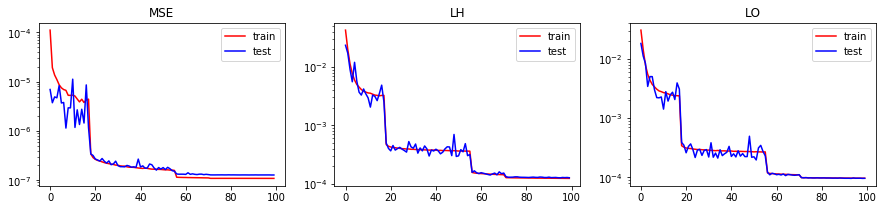

In [9]:
plot_losses(train_loss_history, test_loss_history, NETWORK_NAME)

In [12]:
validation_experiment

4

constant_approximation MSE:	 0.0025871852
constant_approximation MAE:	 0.0053391205
предсказание нейронной сети на один шаг вперёд:
MSE:	 1.0577172e-07
MAE:	 0.00016234448
предсказание нейронной сети на много шагов вперёд:
MSE:	 0.011874206
MAE:	 0.069879584


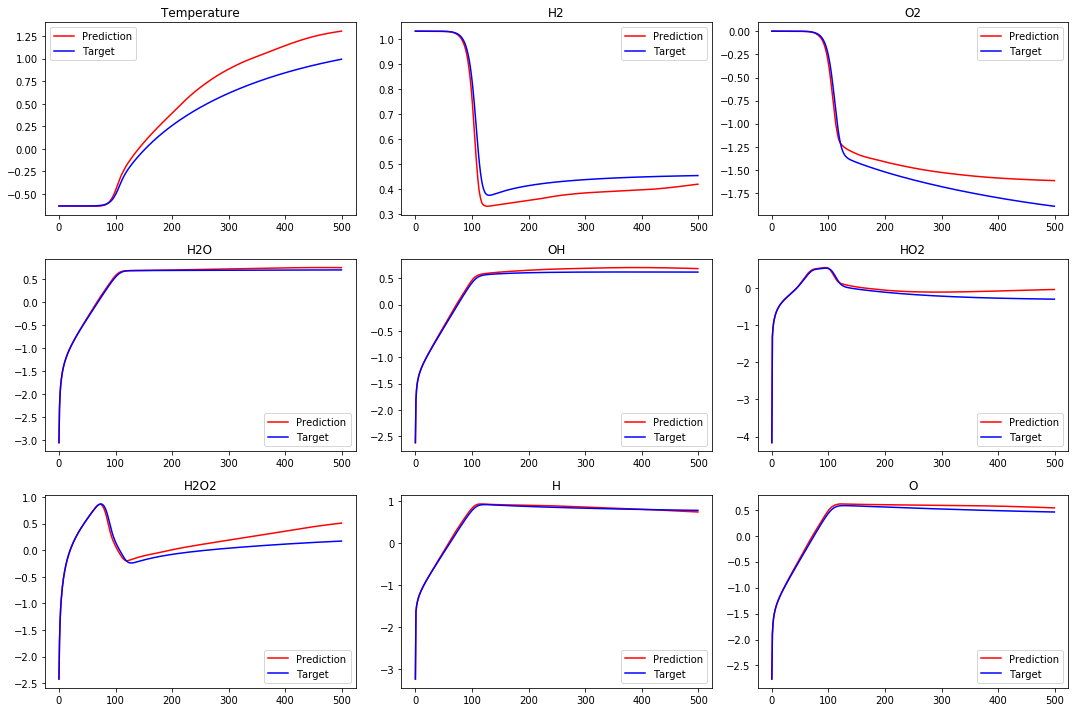

In [11]:
prediction, validation = validate_prediction(model, STEPS_PREV, valid_set, validation_experiment, device, NETWORK_NAME, nsteps=500, show=True)

## Проверка предсказания на несколько шагов вперёд

constant_approximation MSE:	 0.0025871852
constant_approximation MAE:	 0.0053391205
предсказание нейронной сети на один шаг вперёд:
MSE:	 5.6495555e-05
MAE:	 0.0018622997
предсказание нейронной сети на много шагов вперёд:
MSE:	 5874946.0
MAE:	 868.25574


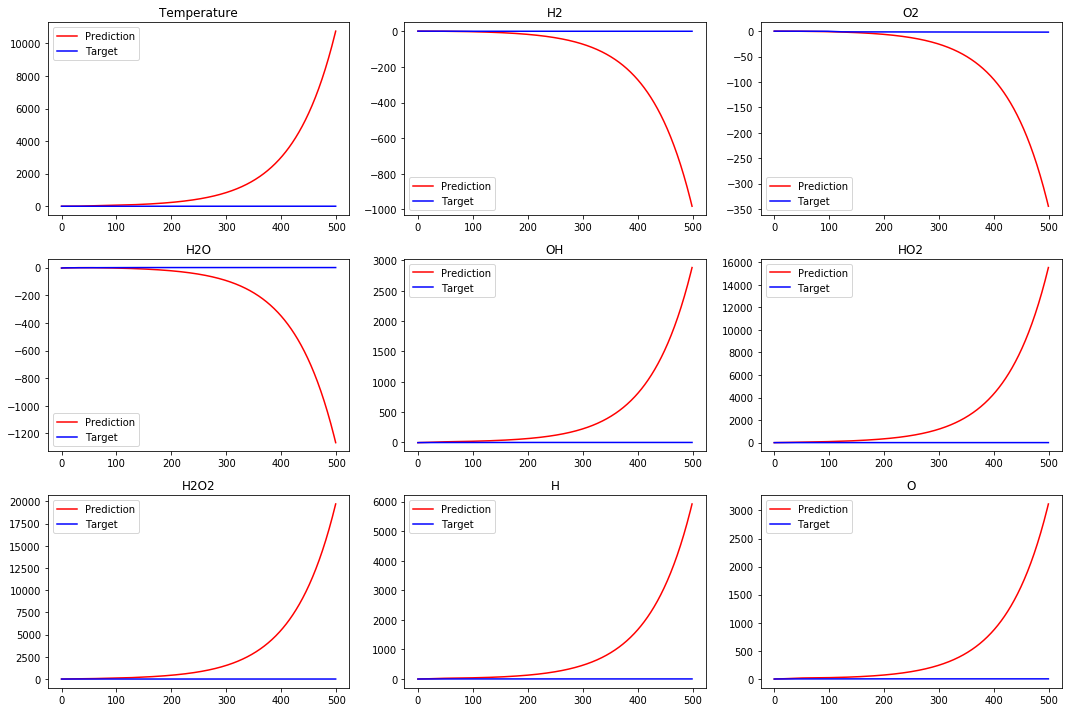

In [11]:
# Берём один эксперимент из данных из валидационной выборки
Validation = torch.FloatTensor(valid_set.data[4]).to(device).unsqueeze(1)
#Validation = torch.FloatTensor(valid_set.data[validation_experiment]).to(device).unsqueeze(1)
#Validation = torch.FloatTensor(train_set.data[validation_experiment]).to(device).unsqueeze(1)

# уберём часть первых шагов, поскольку на них много нулей и таких данных мало в обучающей выборке
shift = 0
Validation = Validation[shift:]

# Стартовое состояние X0
X0 = Validation[:STEPS_PREV, :, :]

Prediction_future = predict_on_many_steps(model=model, X0=X0, N_steps=len(Validation))
Prediction_one_step = predict_on_one_step(model=model, Validation=Validation, device=device, t_prev=1)
Validation = Validation.squeeze().cpu().detach().numpy()

one_step_approximation_errors(Validation)
print('предсказание нейронной сети на один шаг вперёд:')
print_errors(Prediction_one_step, Validation)
print('предсказание нейронной сети на много шагов вперёд:')
print_errors(Prediction_future, Validation)

plot_errors(Prediction_future, Validation, nsteps=500, NETWORK_NAME=NETWORK_NAME)

constant_approximation MSE:	 0.0025871852
constant_approximation MAE:	 0.0053391205
предсказание нейронной сети на один шаг вперёд:
предсказание нейронной сети на много шагов вперёд:


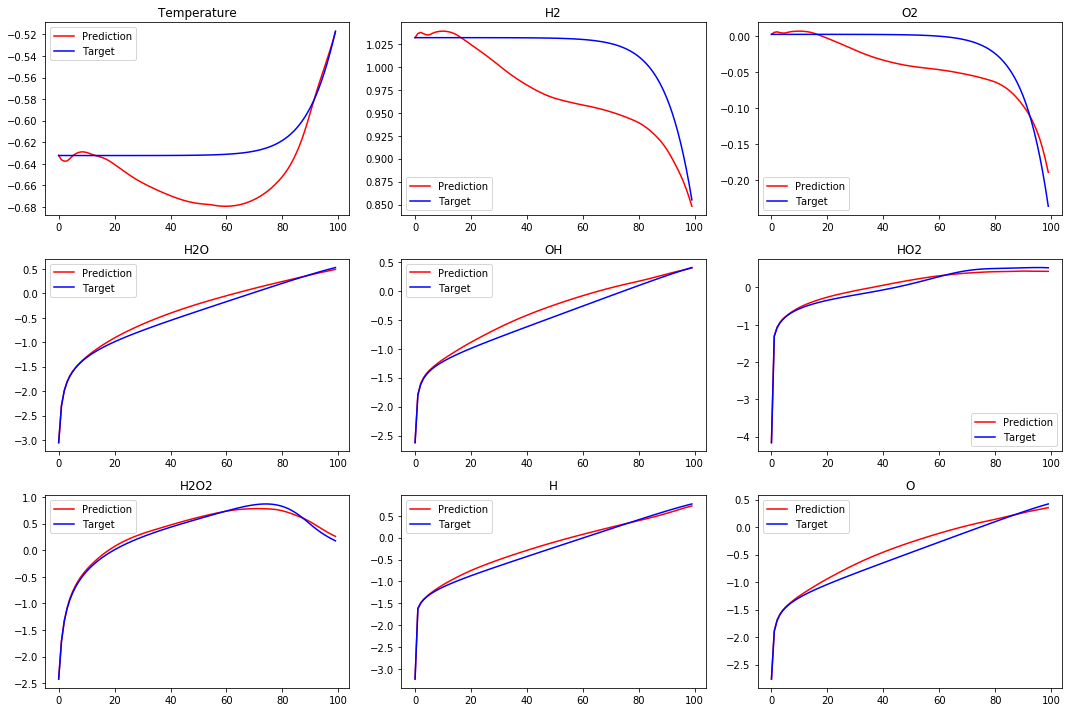

In [21]:
# Берём один эксперимент из данных из валидационной выборки
Validation = torch.FloatTensor(valid_set.data[4]).to(device).unsqueeze(1)
#Validation = torch.FloatTensor(valid_set.data[validation_experiment]).to(device).unsqueeze(1)
#Validation = torch.FloatTensor(train_set.data[validation_experiment]).to(device).unsqueeze(1)

# уберём часть первых шагов, поскольку на них много нулей и таких данных мало в обучающей выборке
shift = 0
Validation = Validation[shift:]

# Стартовое состояние X0
X0 = Validation[:STEPS_PREV, :, :]

Prediction_future = predict_on_many_steps(model=model, X0=X0, N_steps=len(Validation))
Prediction_one_step = predict_on_one_step(model=model, Validation=Validation, device=device, t_prev=1)
Validation = Validation.squeeze().cpu().detach().numpy()

one_step_approximation_errors(Validation)
print('предсказание нейронной сети на один шаг вперёд:')
#print_errors(Prediction_one_step, Validation)
print('предсказание нейронной сети на много шагов вперёд:')
#print_errors(Prediction_future, Validation)

plot_errors(Prediction_future, Validation, nsteps=100, NETWORK_NAME=NETWORK_NAME)

In [47]:
mse_list = []
for v in range(400):
    # Берём один эксперимент из данных из валидационной выборки
    Validation = torch.FloatTensor(valid_set.data[v]).to(device).unsqueeze(1)
    # Стартовое состояние X0
    X0 = Validation[:STEPS_PREV, :, :]
    Prediction_future = predict_on_many_steps(model=model, X0=X0, N_steps=len(Validation))
    Validation = Validation.squeeze().cpu().detach().numpy()
    MSE_error = ((Prediction_future - Validation)**2).mean()
    #print(v, "MSE:\t", MSE_error)
    mse_list.append(MSE_error)

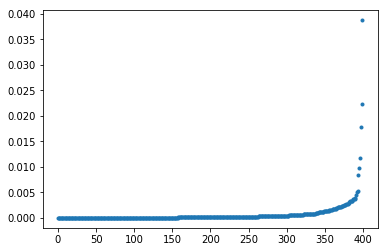

In [70]:
#plt.plot(mse_list, '.')
plt.plot(sorted(mse_list), '.')

In [69]:
mse_list.index(max(mse_list)), max(mse_list)

(288, 0.038724553)

In [71]:
sorted(enumerate(mse_list), key=lambda x: x[1], reverse=True)

[(288, 0.038724553),
 (140, 0.02232637),
 (180, 0.017812861),
 (57, 0.011773921),
 (24, 0.009867814),
 (37, 0.008453468),
 (339, 0.005253684),
 (36, 0.004990717),
 (351, 0.0045377496),
 (300, 0.0039076363),
 (348, 0.0037078324),
 (358, 0.003655475),
 (184, 0.0036527454),
 (307, 0.0034084741),
 (50, 0.0033790742),
 (164, 0.0033672017),
 (128, 0.0032712894),
 (135, 0.0031314301),
 (108, 0.0028410146),
 (325, 0.0027414854),
 (399, 0.0027085291),
 (205, 0.0026386941),
 (100, 0.0026086266),
 (188, 0.0024993753),
 (117, 0.0024944511),
 (312, 0.0024147404),
 (80, 0.0023856375),
 (335, 0.0023217094),
 (360, 0.00217974),
 (172, 0.0021740196),
 (208, 0.0021626793),
 (15, 0.0021586032),
 (226, 0.0020696106),
 (371, 0.0019344751),
 (147, 0.0018539258),
 (398, 0.0018270983),
 (62, 0.001803904),
 (267, 0.0017795691),
 (377, 0.0017253715),
 (114, 0.0017086848),
 (207, 0.001578497),
 (257, 0.0015711288),
 (222, 0.0015440293),
 (330, 0.0014754963),
 (12, 0.001457446),
 (387, 0.0014468855),
 (224, 0.001

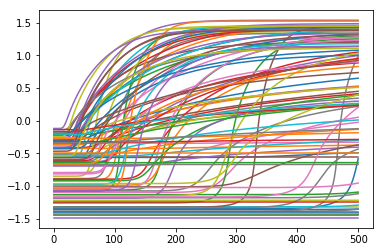

In [38]:
plt.figure()
for i in range(100):
    plt.plot(valid_set.data[i][:,0])

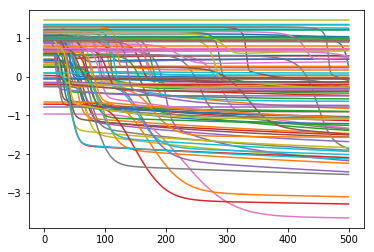

In [39]:
plt.figure()
for i in range(100):
    plt.plot(valid_set.data[i][:,1])

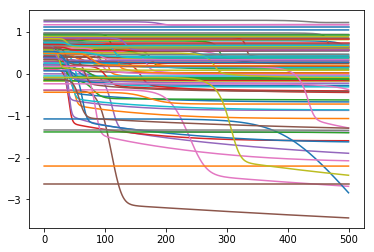

In [40]:
plt.figure()
for i in range(100):
    plt.plot(valid_set.data[i][:,2])

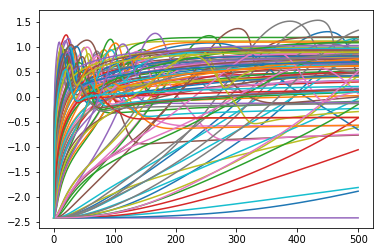

In [42]:
plt.figure()
for i in range(100):
    plt.plot(valid_set.data[i][:,6])